# Модель, прогнозирующая отказ от брони в отеле

**Заказчик:** сеть отелей «Как в гостях» (интересная игра слов, если приглядеться).

**Входные данные:** информация с характеристиками заказов; данные изначально разделены на обучающий и тестовый наборы.

**Цель проекта:** разработать систему, предсказывающую отказ от брони (заказа). Если модель покажет, что бронь будет отменена,  клиенту предложат внести депозит в размере 80% от стоимости номера за сутки и затрат на разовую уборку. Депозит пойдет в прибыль отеля, если клиент отменит бронь.

**Задачи проекта:**

- провести исследовательский анализ данных;
- оценить прибыль отеля до внедрения депозитов;
- выбрать метрику для обучения моделей;
- обучить разные модели и оценить их качество кросс-валидацией;
- выбрать лучшую модель и проверить ее на тестовой выборке;
- оценить прибыль, которую принесет выбранная модель;
- на основе исследовательского анализа выявить признаки клиента, склонного к отмене заказа;
- дать рекомендации по дальнейшему развитию данного проекта.

**Бизнес-метрика и другие данные**

Основная бизнес-метрика для любой сети отелей — ее прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.  
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то уборку делают каждые 2 дня.  
Стоимость номеров отеля:

    категория A: за ночь — 1000, разовое обслуживание — 400;
    категория B: за ночь — 800,  разовое обслуживание — 350;
    категория C: за ночь — 600,  разовое обслуживание — 350;
    категория D: за ночь — 550,  разовое обслуживание — 150;
    категория E: за ночь — 500,  разовое обслуживание — 150;
    категория F: за ночь — 450,  разовое обслуживание — 150;
    категория G: за ночь — 350,  разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесет компании.

**Пояснения к оформлению**

Основные таблицы с данными обозначаются как **"data"**.  

Временные таблицы с данными обозначаются как **"df"**.  

Промежуточные выводы выделены так:

> Промежутчный вывод.

## Начальная подготовка

### Импорты

In [1]:
import pandas as pd
import numpy as np

import os
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio

<a id="id_constants"></a>
### Константы

In [2]:
RANDOM_STATE = RS = 99    # константа для параметра random_state
CR = '\n'                 # новая строка
N_TRIALS = 200            # количество попыток для Optuna
TIMEOUT = 300             # максимальный порог времени для Optuna
SCORING = 'f1'            # основная метрика

### Вспомогательные функции 

In [3]:
def custom_read_csv(path_local, separator=','):
    """
    чтение датасета:
      сначала из локального хранилища;
      при неудаче — из удаленного хранилища (добавление слеша – особенности синтаксиса линукса или как там его)
    """

    path_remote = '/' + path_local

    if os.path.exists(path_local):
        return pd.read_csv(path_local, sep=separator)

    elif os.path.exists(path_remote):
        return pd.read_csv(path_remote, sep=separator)

    else:
        print('Ошибка')

In [4]:
def df_name(df):
    """
    определение имени таблицы
    """
    return [name for name in globals() if globals()[name] is df][0]

In [5]:
def basic_info(df: pd.DataFrame, sample_type='sample', samples=5, describe='all'):
    """
    первичная информация о таблице: info(), sample()/head()/tail(), describe()
    """
    
    # заголовок (имя исследуемого датафрейма)
    
    print(f'\n\nдатафрейм {f.BOLD}{df_name(df)}{f.END}', '≋'*30)


    # метод info()
    
    print('\n\n--- метод info() ---\n')
    print(df.info())

    
    # несколько случайных записей
    
    print(f'\n\n--- метод {sample_type}({samples}) ---')
    
    if sample_type == 'sample':
        display(df.sample(samples))
    elif sample_type == 'head':
        display(df.head(samples))
    elif sample_type == 'tail':
        display(df.tail(samples))
    else:
        print(f'{sample_type} – недопустимое значение параметра "sample_type" ')
    
    
    # метод describe()
    
    print(f'\n\n--- метод describe({describe}) ---')
    
    if describe=='all' or describe=='numeric':
        try:
            display(df.describe(include=np.number))
        except ValueError:
            pass

    if describe=='all' or describe=='categorical':
        try:
            display(df.describe(exclude=np.number).T)
        except ValueError:
            pass
    
    if describe not in ['numeric','categorical','all']:
        print(f'{describe} – недопустимое значение параметра "describe" ')

In [6]:
def plot_Optuna(study, plot_kind='plot_slice', model_name=''):
    '''
    Дополнительная настройка оригинальных графиков Optuna.
    Например, на графике `plot_slice` изначально цвет точек зависел от номера итерации.
    Теперь они все одинакового цвета и полупрозрачные, лучше видны скопления точек.
    
    :study: обученный объект класса OptunaSearchCV
    :plot_kind: тип графика Optuna
    :model_name: название модели
    '''
    
    if plot_kind == 'plot_slice':
        fig = optuna.visualization.plot_slice(study)
        fig.update_traces(
                          marker_color='Darkgrey',
                          marker_size=3,
                          marker_opacity=0.2,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )
    
    elif plot_kind == 'plot_param_importances':
        fig = optuna.visualization.plot_param_importances(study)
        
    elif plot_kind == 'plot_optimization_history':
        fig = optuna.visualization.plot_optimization_history(study)
        fig.update_traces(
                          marker_size=5,
                          marker_opacity=0.3,
                          marker_line_width=1,
                          marker_line_color='Black',
                         )

    fig.update_layout(
                      title_text=model_name,
                      title_x=0,
                      font_size=10,
                     )    
    fig.show()

### Оформление

In [7]:
# выделение в тексте
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [8]:
# оформление графиков по-умолчанию

# Matplotlib, Seaborn
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150                                        # dpi для рендеринга графиков

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
                                               layout_autosize=True,
                                               # width=900,
                                               layout_height=200,
                                               layout_legend_orientation="h",
                                               layout_margin=dict(t=40, b=40),         # (l=0, r=0, b=0, t=0, pad=0)
                                               layout_template='seaborn',
                                              )
pio.templates.default = 'my_theme'

# цвета, цветовые схемы
my_cmap = LinearSegmentedColormap.from_list('', ['steelblue', 'aliceblue', 'steelblue'])

In [9]:
# оформление Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.colheader_justify = 'left'

In [10]:
# оформление Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # отключение вывода логов при работе optuna

In [11]:
# оформление — прочее
warnings.filterwarnings('ignore')

## Чтение и проверка входных данных

Каждый объект в наборе данных – информация о характеристиках одного заказа (бронирования).

`id` — номер записи;  
`adults` — количество взрослых постояльцев;  
`arrival_date_year` — год заезда;  
`arrival_date_month` — месяц заезда;  
`arrival_date_week_number` — неделя заезда;  
`arrival_date_day_of_month` — день заезда;  
`babies` — количество младенцев;  
`booking_changes` — количество изменений параметров заказа;  
`children` — количество детей от 3 до 14 лет;  
`country` — гражданство постояльца;  
`customer_type` — тип заказчика:  
= **Contract** — договор с юридическим лицом;  
= **Group** — групповой заезд;  
= **Transient** — не связано с договором или групповым заездом;  
= **Transient-party** — не связано с договором или групповым заездом, но связано с бронированием типа Transient;  
`days_in_waiting_list` — сколько дней заказ ожидал подтверждения;  
`distribution_channel` — канал дистрибуции заказа;  
`is_canceled` — отмена заказа;  
`is_repeated_guest` — признак того, что гость бронирует номер второй раз;  
`lead_time` — количество дней между датой бронирования и датой прибытия;  
`meal` — опции заказа:  
= **SC** — нет дополнительных опций;  
= **BB** — включён завтрак;  
= **HB** — включён завтрак и обед;  
= **FB** — включён завтрак, обед и ужин;  
`previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;  
`previous_cancellations` — количество отменённых заказов у клиента;  
`required_car_parking_spaces` — необходимость места для автомобиля;  
`reserved_room_type` — тип забронированной комнаты;  
`stays_in_weekend_nights` — количество ночей в выходные дни;  
`stays_in_week_nights` — количество ночей в будние дни;  
`total_nights` — общее количество ночей;  
`total_of_special_requests` — количество специальных отметок.

### Чтение данных

In [12]:
data = custom_read_csv('datasets/hotel_train.csv')      # данные для обучения
data_test = custom_read_csv('datasets/hotel_test.csv')  # данные для проверки

### Первичная информация о данных

In [13]:
basic_info(data)
basic_info(data_test)



датафрейм data ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies               

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
38499,56854,1,311.000,2015,August,35,24,1,1,2.000,0.000,0.000,BB,PRT,TA/TO,0,1,0,A,0,0,Transient-Party,0,0,2
24115,32055,1,46.000,2016,March,10,4,0,2,2.000,0.000,0.000,SC,ITA,TA/TO,0,0,0,A,0,0,Transient,0,0,2
3666,3702,0,199.000,2016,May,19,2,1,1,2.000,0.000,0.000,HB,DEU,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,2
45371,63816,1,68.000,2016,February,8,17,0,2,2.000,0.000,0.000,BB,PRT,TA/TO,0,1,0,A,0,0,Transient,0,0,2
60094,78772,0,40.000,2016,September,40,28,0,2,2.000,0.000,0.000,BB,BEL,TA/TO,0,0,0,D,1,0,Transient,1,2,2




--- метод describe(all) ---


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000
mean,43544.069,0.369,96.338,2015.719,31.340,15.848,0.825,2.225,1.837,0.075,0.007,0.027,0.129,0.108,0.194,3.334,0.057,0.513,3.050
std,25614.859,0.482,96.128,0.449,13.464,8.748,0.853,1.355,0.480,0.334,0.099,0.163,0.965,1.327,0.594,18.240,0.232,0.753,1.738
min,0.000,0.000,0.000,2015.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,19108.000,0.000,17.000,2015.000,21.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,40554.000,0.000,64.000,2016.000,34.000,16.000,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
75%,67414.000,1.000,151.000,2016.000,42.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000
max,84121.000,1.000,374.000,2016.000,53.000,31.000,4.000,6.000,4.000,3.000,10.000,1.000,26.000,58.000,17.000,259.000,3.000,5.000,10.000


,count,unique,top,freq
arrival_date_month,65229,12,October,9255
meal,65229,5,BB,51697
country,65229,155,PRT,28831
distribution_channel,65229,4,TA/TO,54454
reserved_room_type,65229,7,A,50501
customer_type,65229,4,Transient,45493




датафрейм data_test ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋


--- метод info() ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies          

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2061,8168,1,315.000,2017,August,34,20,2,3,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,2,0,Transient,0,1,5
23918,89410,0,138.000,2017,April,15,9,2,3,3.000,0.000,0.000,BB,DNK,TA/TO,0,0,0,D,0,0,Transient,0,3,5
28776,94268,0,78.000,2017,June,26,28,0,2,2.000,0.000,0.000,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,2
3255,20172,0,3.000,2017,January,4,27,1,2,1.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
16982,54171,1,17.000,2017,July,30,26,0,4,2.000,0.000,0.000,BB,ESP,TA/TO,0,0,0,E,0,0,Transient,0,1,4




--- метод describe(all) ---


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000
mean,60131.505,0.388,97.588,2017.000,17.804,15.657,0.868,2.340,1.859,0.084,0.006,0.031,0.012,0.171,0.217,0.262,0.046,0.658,3.208
std,29953.586,0.487,86.507,0.000,9.177,8.766,0.853,1.375,0.489,0.343,0.076,0.174,0.180,1.875,0.641,4.733,0.219,0.834,1.739
min,6086.000,0.000,0.000,2017.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,45291.750,0.000,23.000,2017.000,10.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,53394.500,0.000,76.000,2017.000,18.000,15.500,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
75%,89800.250,1.000,155.000,2017.000,25.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000
max,97903.000,1.000,373.000,2017.000,35.000,31.000,4.000,6.000,4.000,3.000,2.000,1.000,6.000,72.000,18.000,223.000,8.000,5.000,10.000


,count,unique,top,freq
arrival_date_month,32412,8,May,5262
meal,32412,5,BB,24684
country,32412,143,PRT,9887
distribution_channel,32412,4,TA/TO,27083
reserved_room_type,32412,7,A,23471
customer_type,32412,4,Transient,27461


> Пропусков нет – спасибо команде Практикума )) 

### Проверка на дубликаты

In [14]:
data.duplicated().sum(), data_test.duplicated().sum()

(0, 0)

> Явных дубликатов нет.

### Удаление ненужных полей

In [15]:
data = data.drop(['id'], axis=1)
data_test = data_test.drop(['id'], axis=1)

data.sample()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
14710,0,261.000,2016,October,41,6,0,2,2.000,0.000,0.000,HB,DEU,TA/TO,0,0,0,D,0,0,Transient-Party,0,0,2


> Идентификатор записи, скорее всего, для модели не пригодится.

### Проверка и правка значений

In [16]:
data.meal.unique(), data.reserved_room_type.unique()

(array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
       dtype=object),
 array(['A               ', 'C               ', 'D               ',
        'E               ', 'G               ', 'F               ',
        'B               '], dtype=object))

In [17]:
for column in ['meal', 'reserved_room_type']:
    data[column] = data[column].str.strip(' ')                # обучающий датасет
    data_test[column] = data_test[column].str.strip(' ')      # тестовый датасет

In [18]:
data.meal.unique(), data.reserved_room_type.unique()

(array(['BB', 'FB', 'HB', 'SC'], dtype=object),
 array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object))

> Удалены ненужные пробелы в обозначениях типа комнаты и типа питания.

## Исследовательский анализ

### Сбалансированность датасета по целевому признаку

In [19]:
data.is_canceled.value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

> Средняя доля отказов: 37%.

> Есть некоторый дисбаланс: подтвержденных заказов почти вдвое больше.  
> При создании моделей необходимо это учесть. 

### Распределение признаков с учетом `is_canceled`

#### Графики распределений признаков типа object

In [20]:
# временная таблица без лишних полей

obj_fields = data.select_dtypes(exclude=[np.number]).columns.to_list() + ['is_canceled']
df = data[obj_fields].drop(['country'], axis=1).copy()

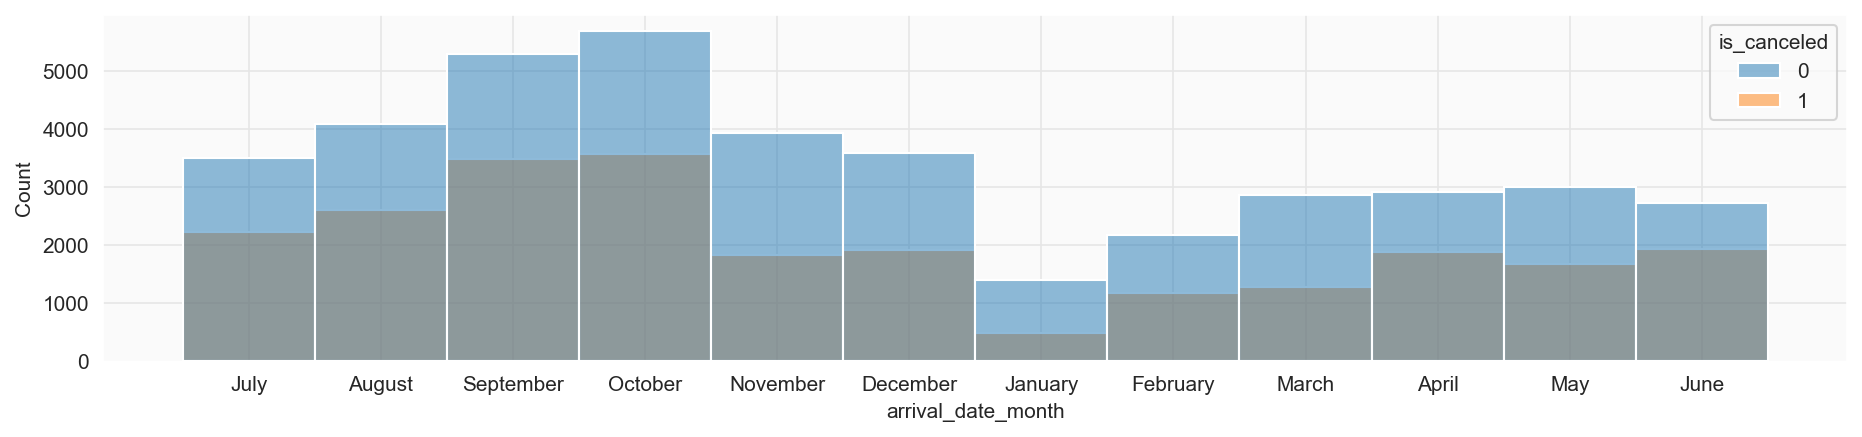

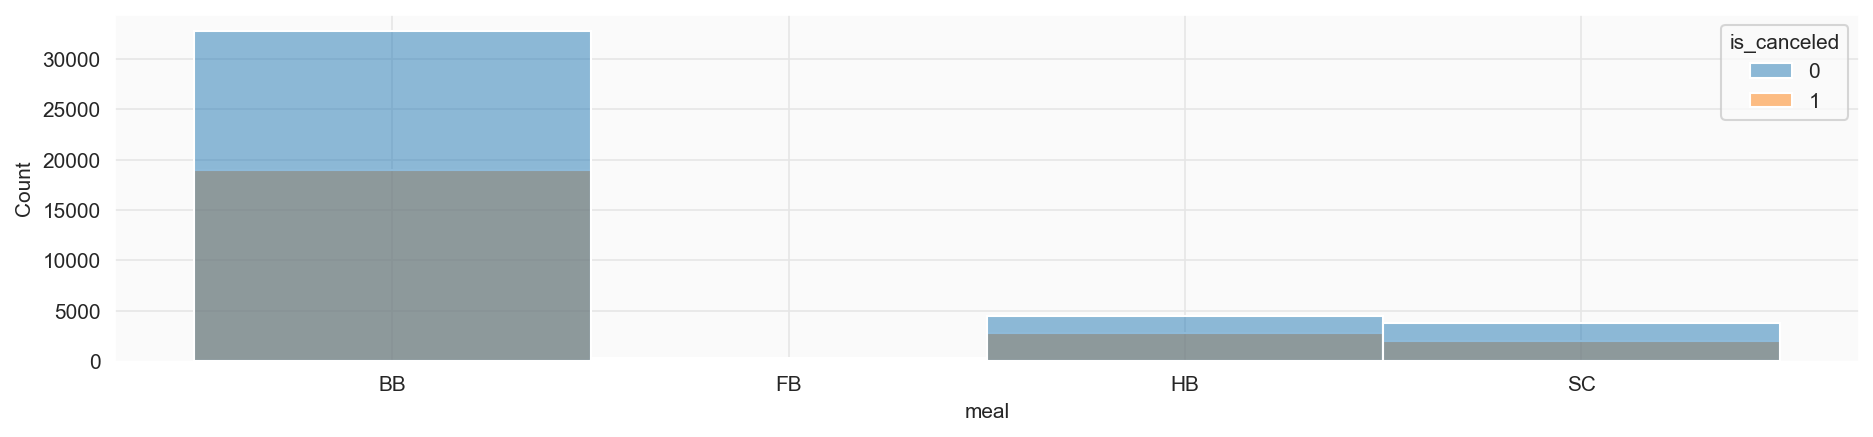

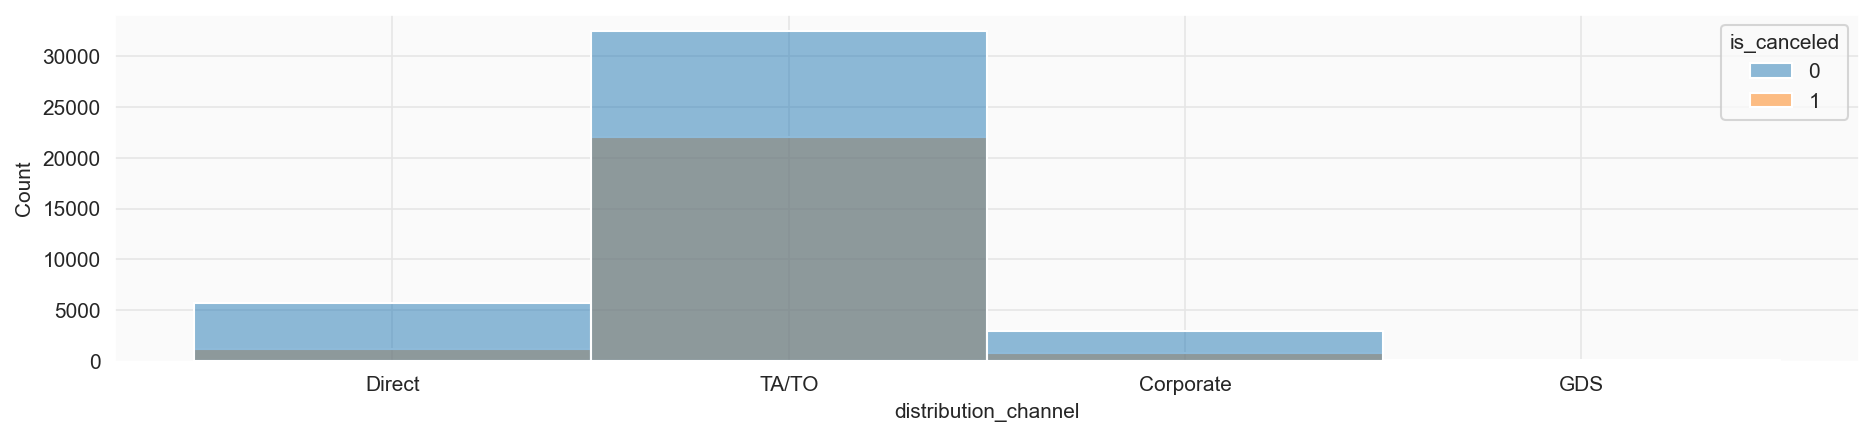

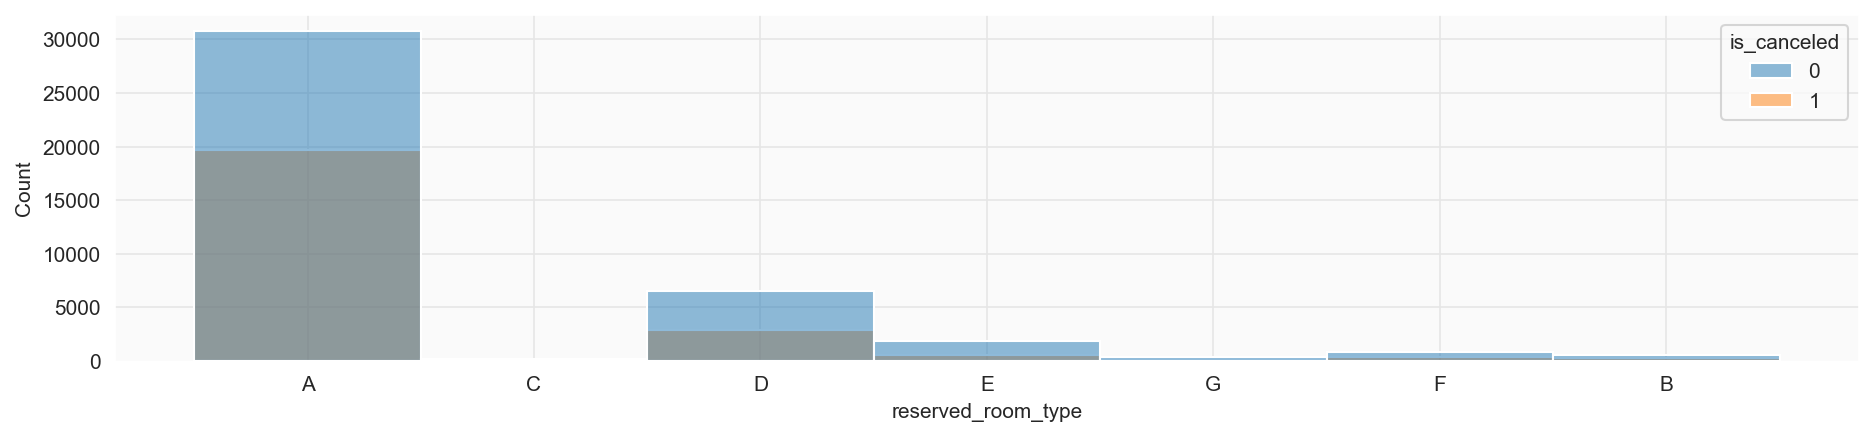

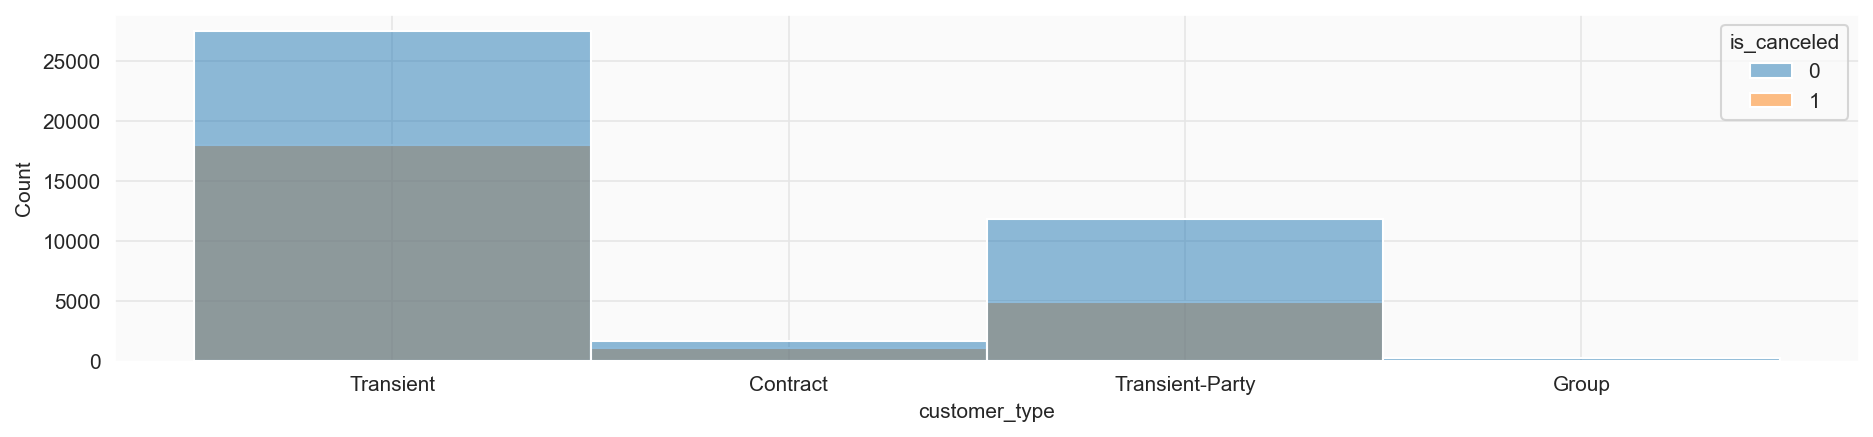

In [21]:
for column in df.drop('is_canceled', axis=1).columns:
    fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
    sns.histplot(x=df[column], hue=df.is_canceled);

Дополнительные, по-своему показательные графики.  
Закомментировал, чтобы не загромождать проект.

In [22]:
# for column in df.drop('is_canceled', axis=1).columns:
#     fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
#     sns.histplot(x=df[column], hue=df.is_canceled, multiple='fill');

#### Графики распределений числовых признаков

In [23]:
# временная таблица без лишних полей

num_fields = data.select_dtypes(include=[np.number]).columns.to_list()
df = data[num_fields]

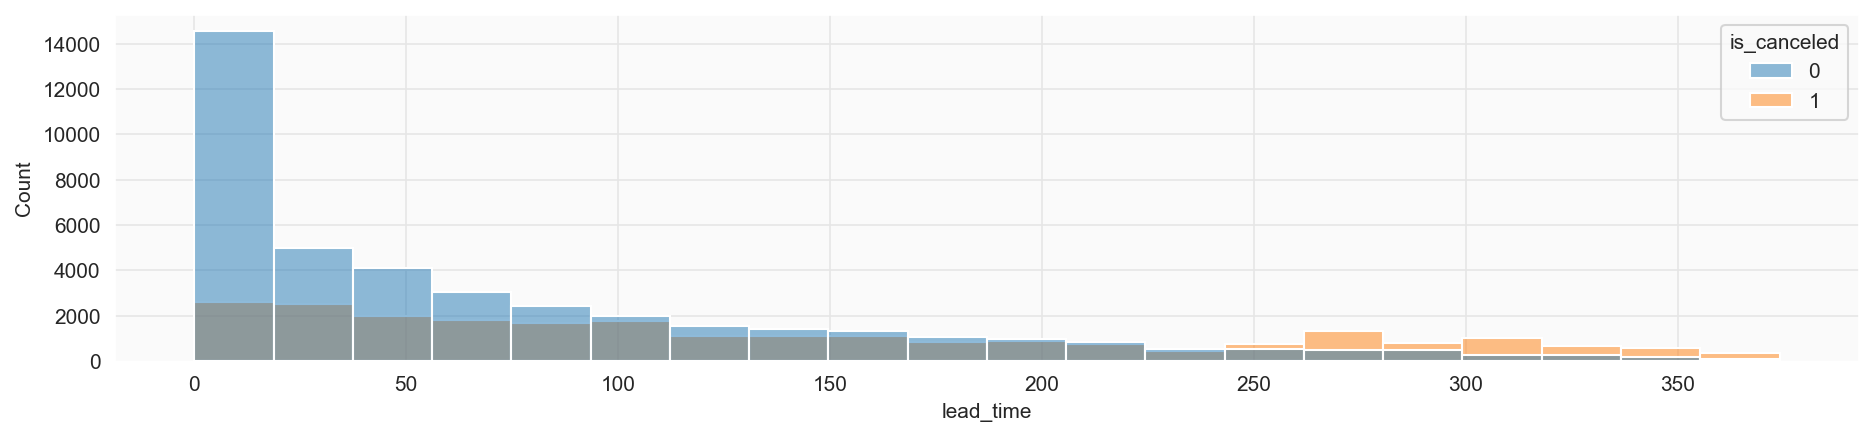

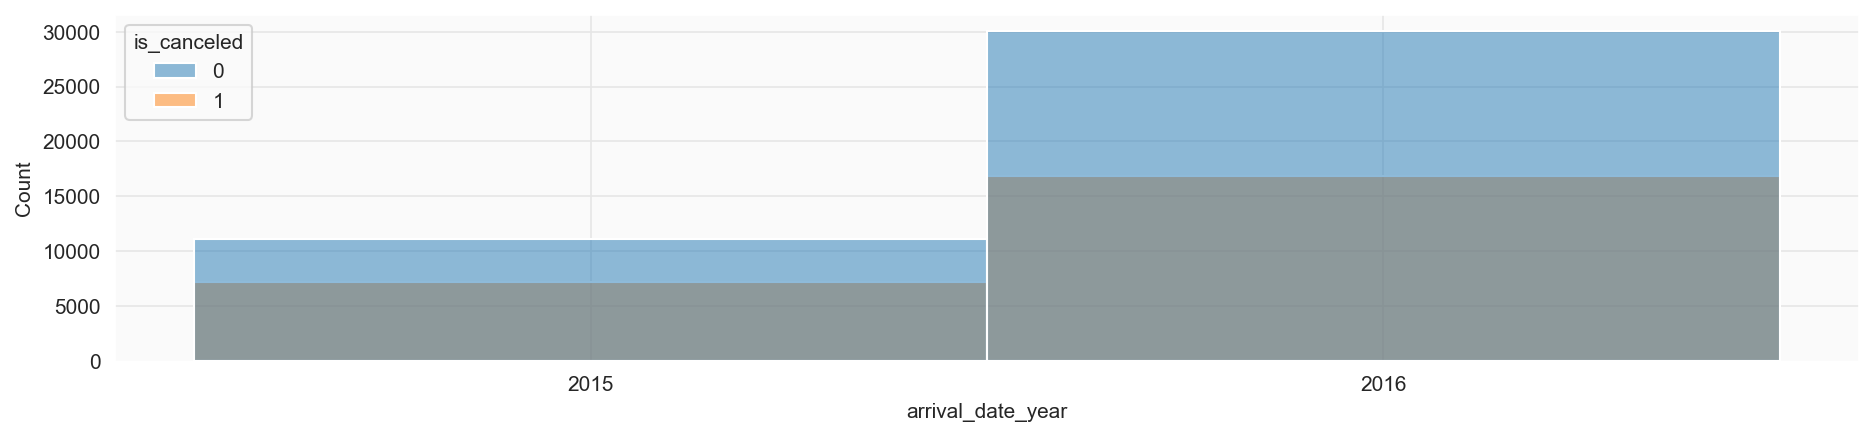

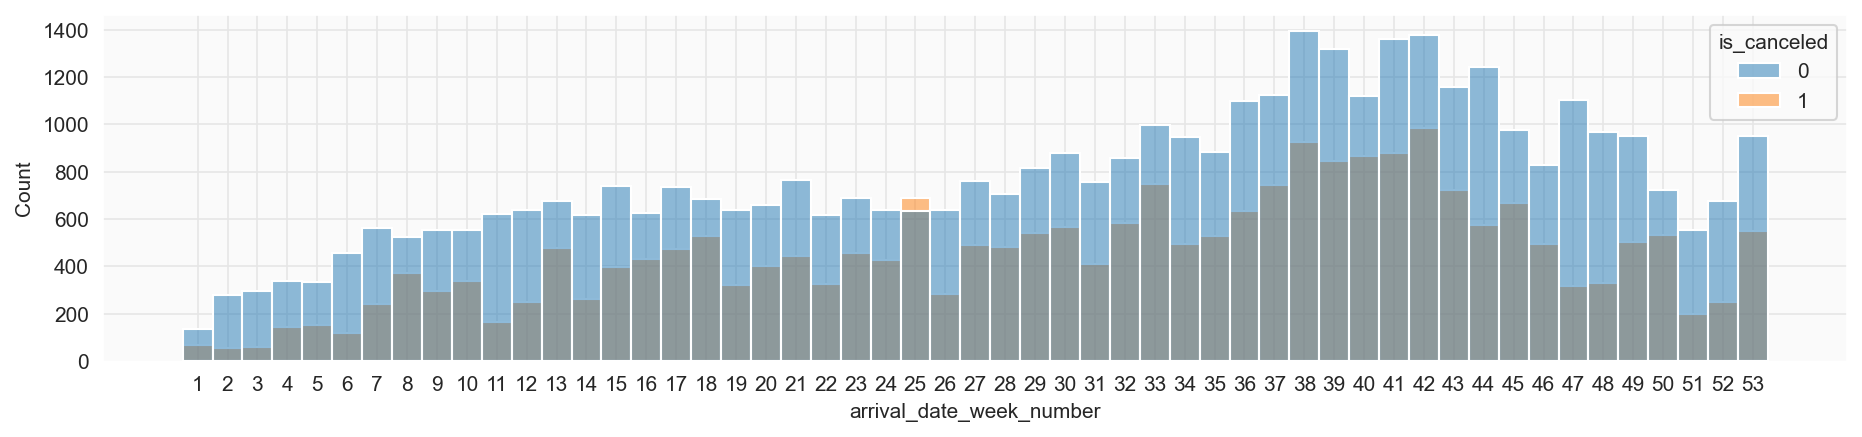

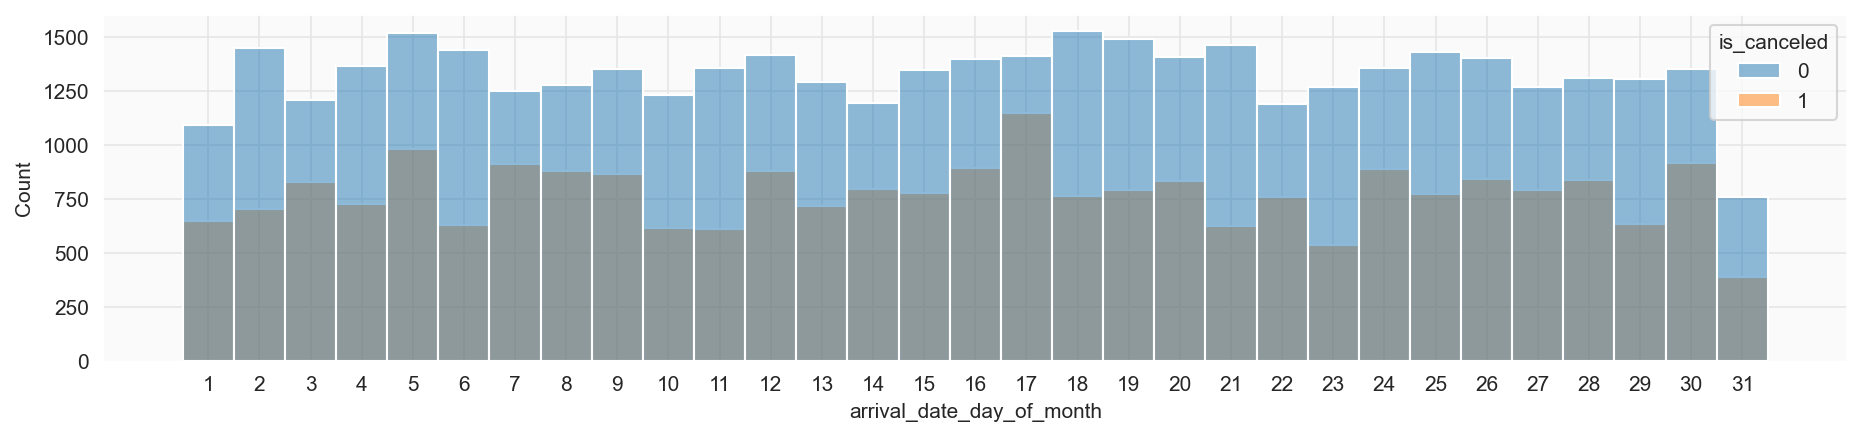

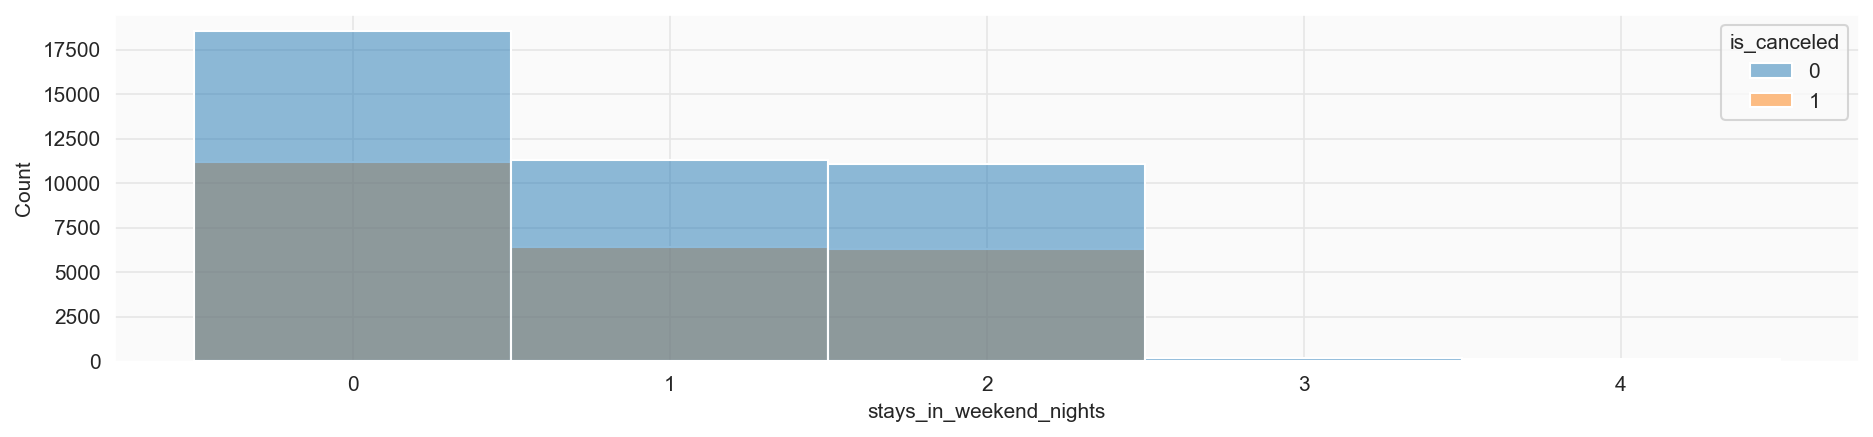

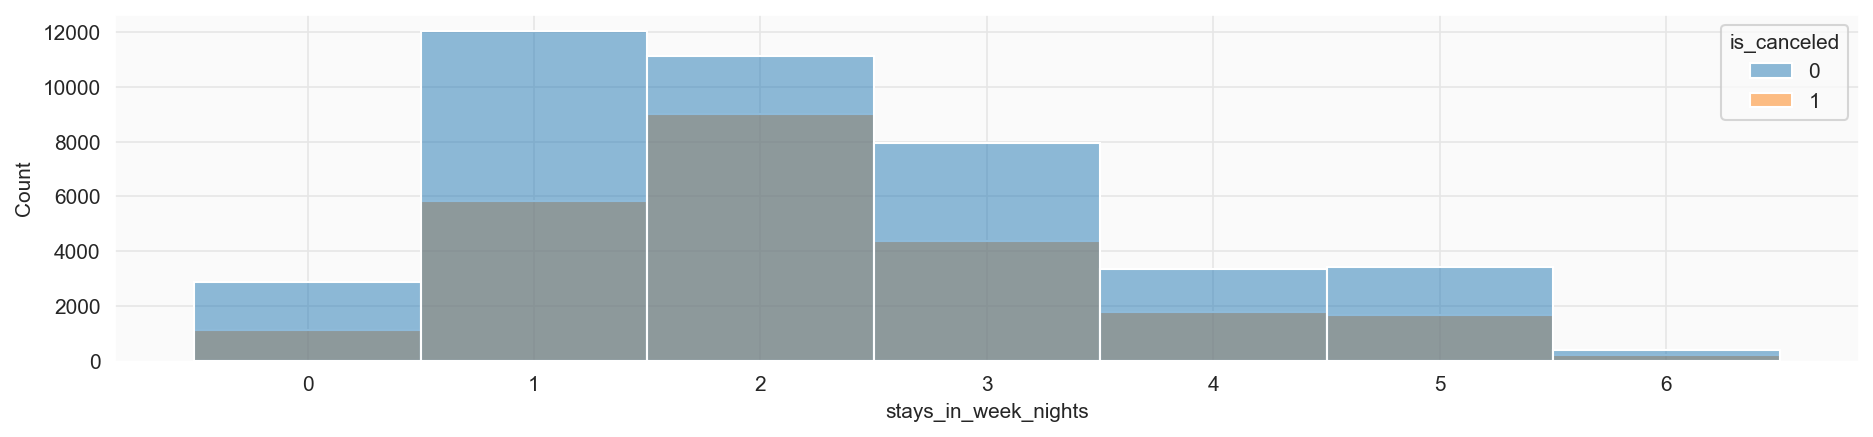

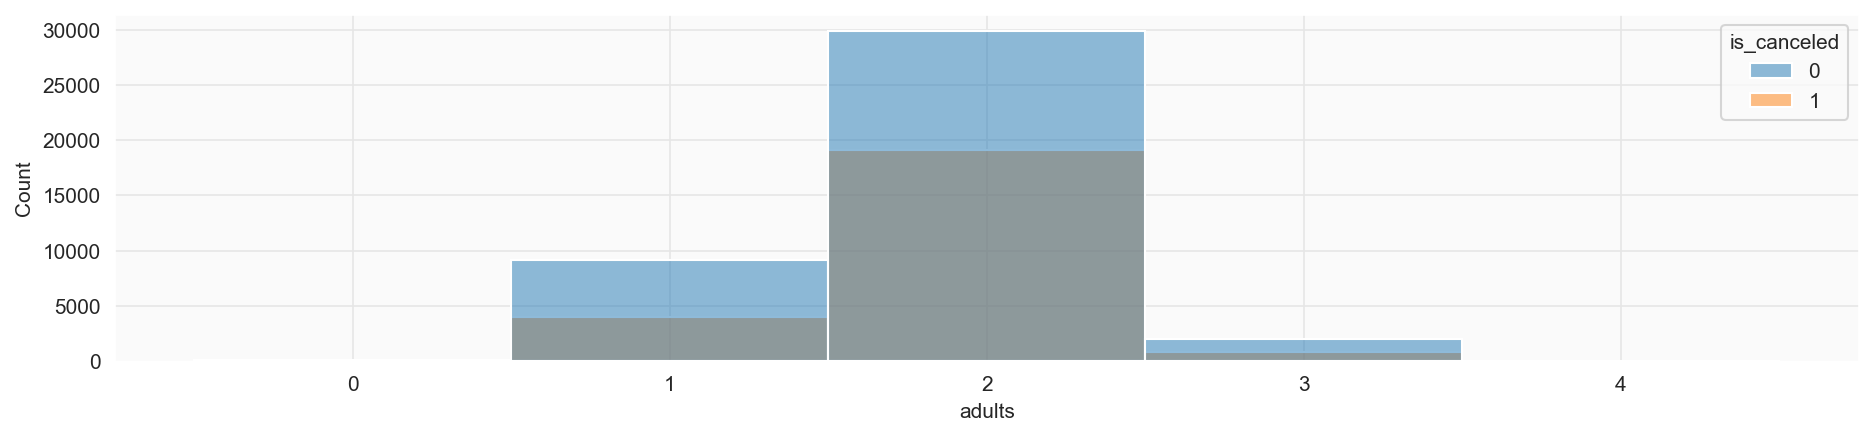

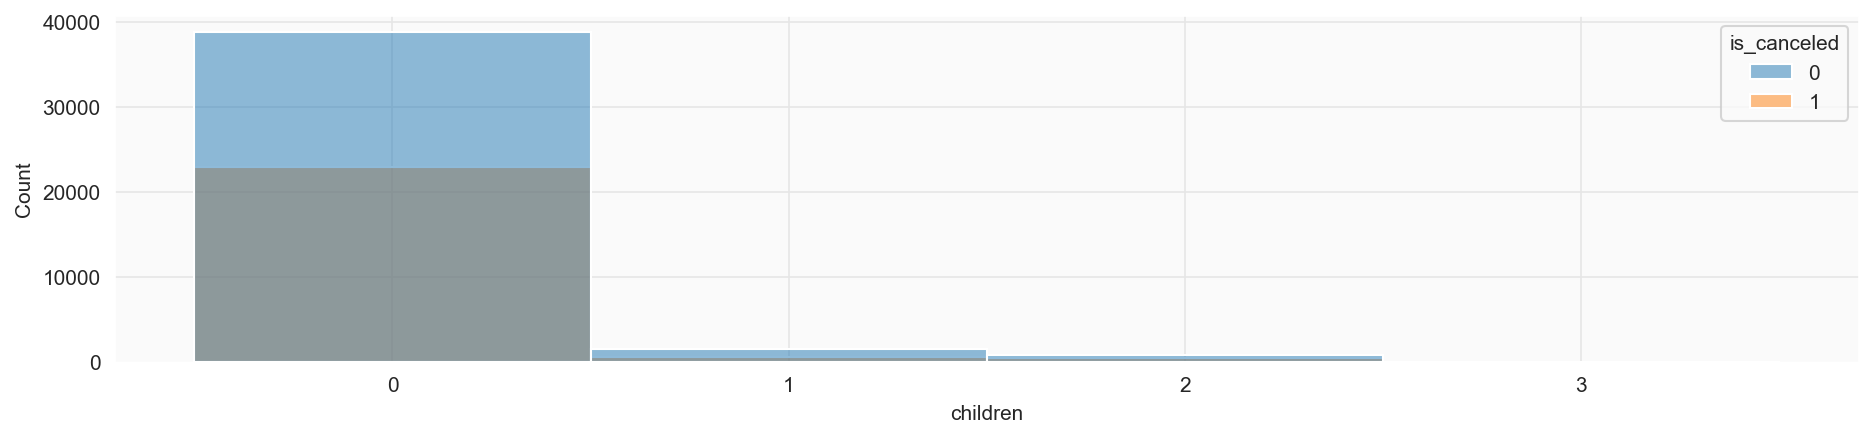

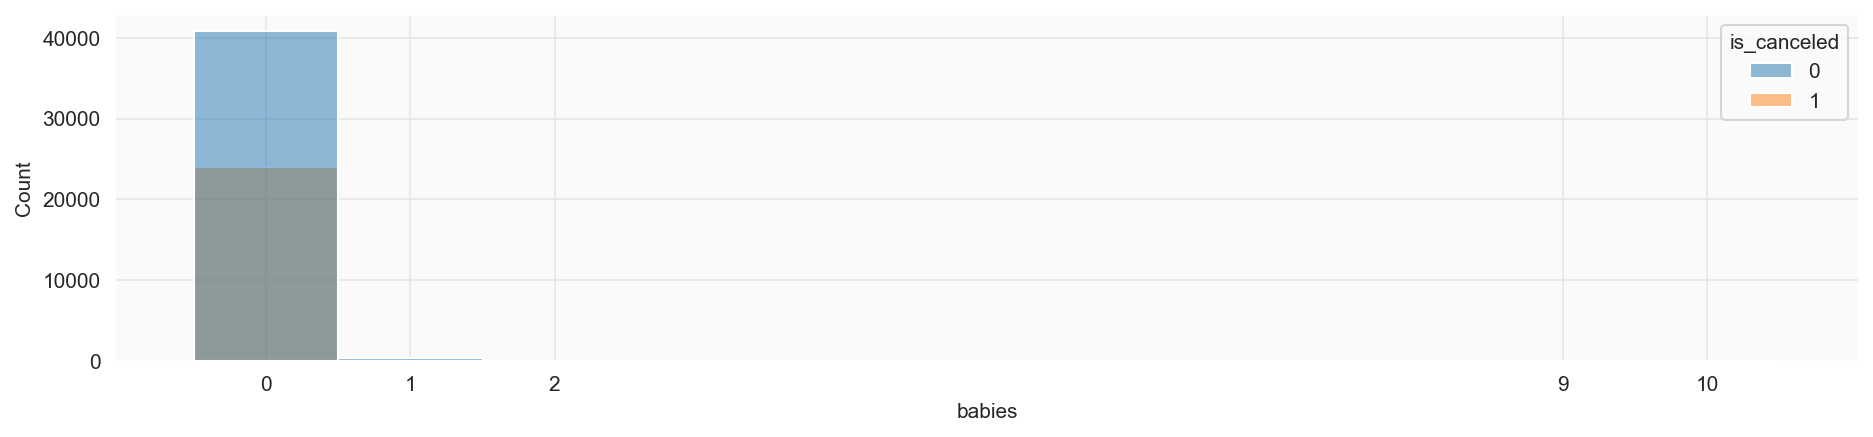

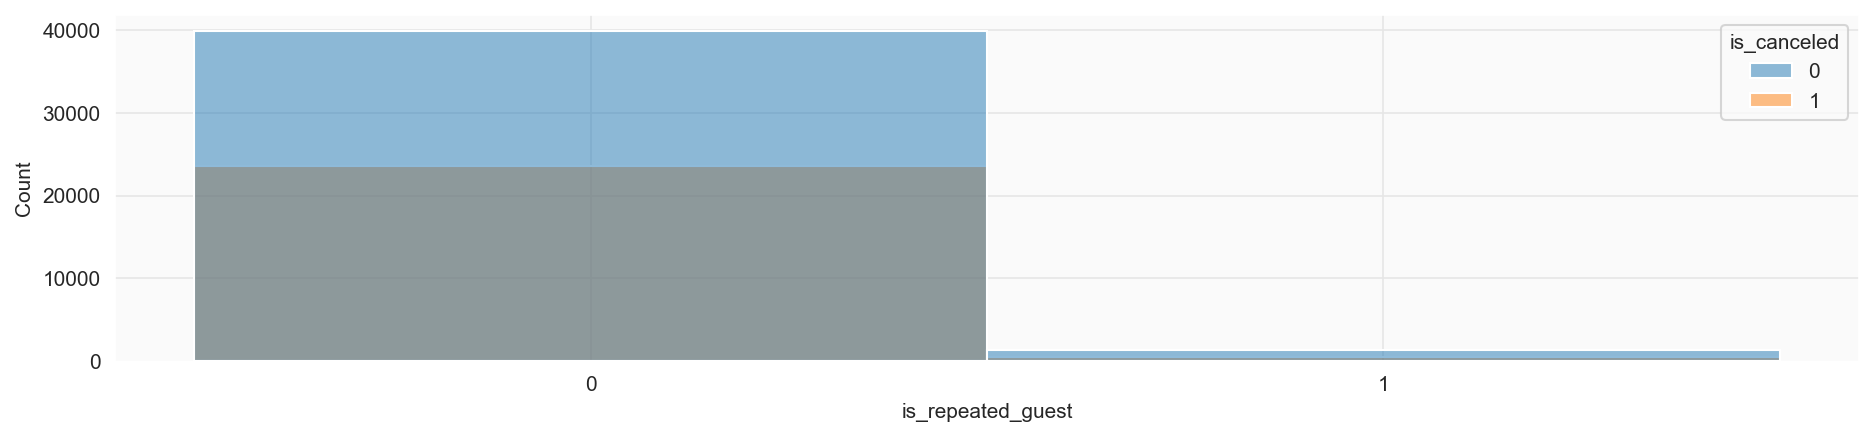

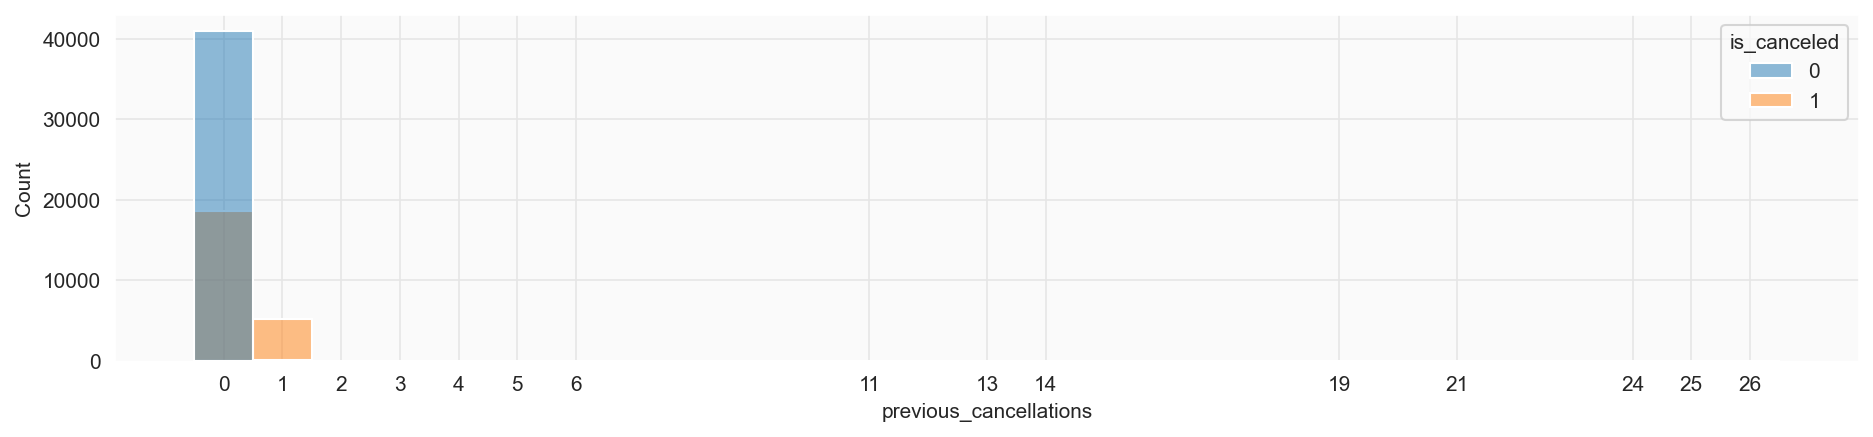

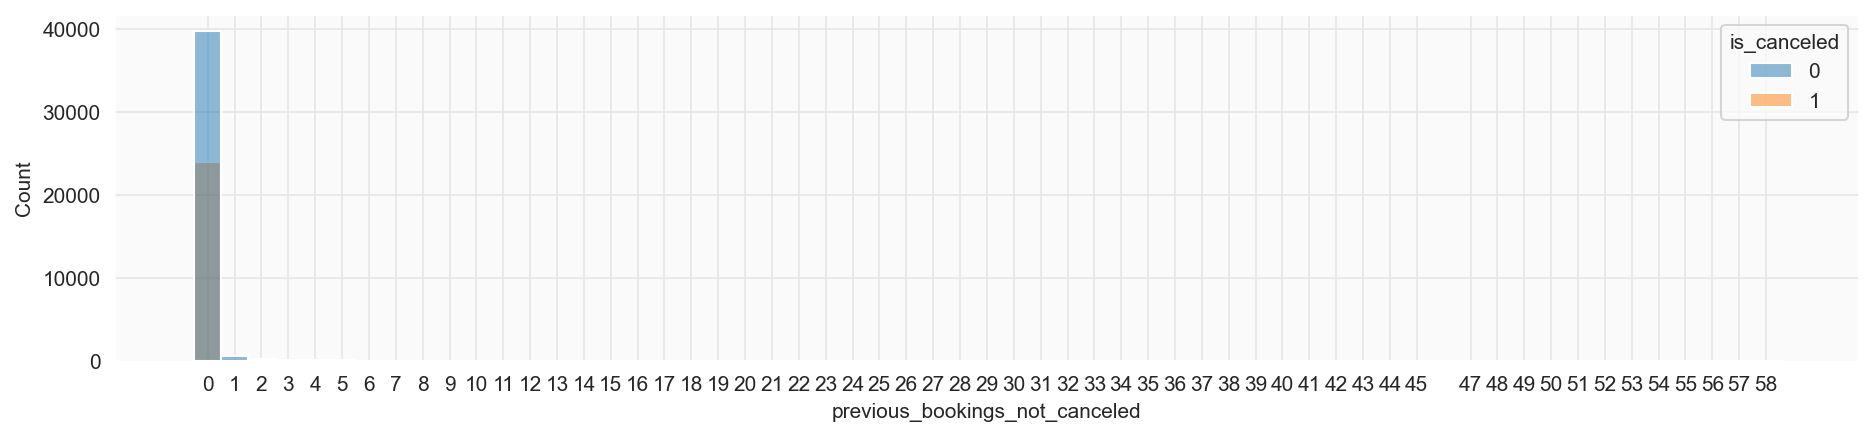

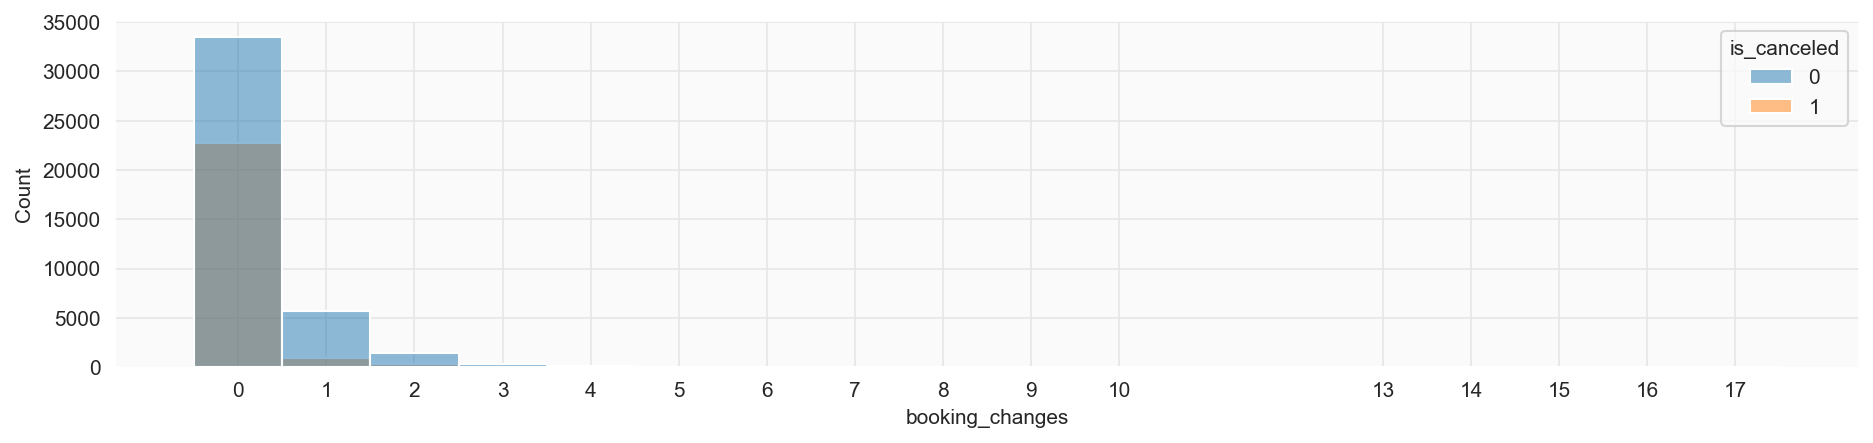

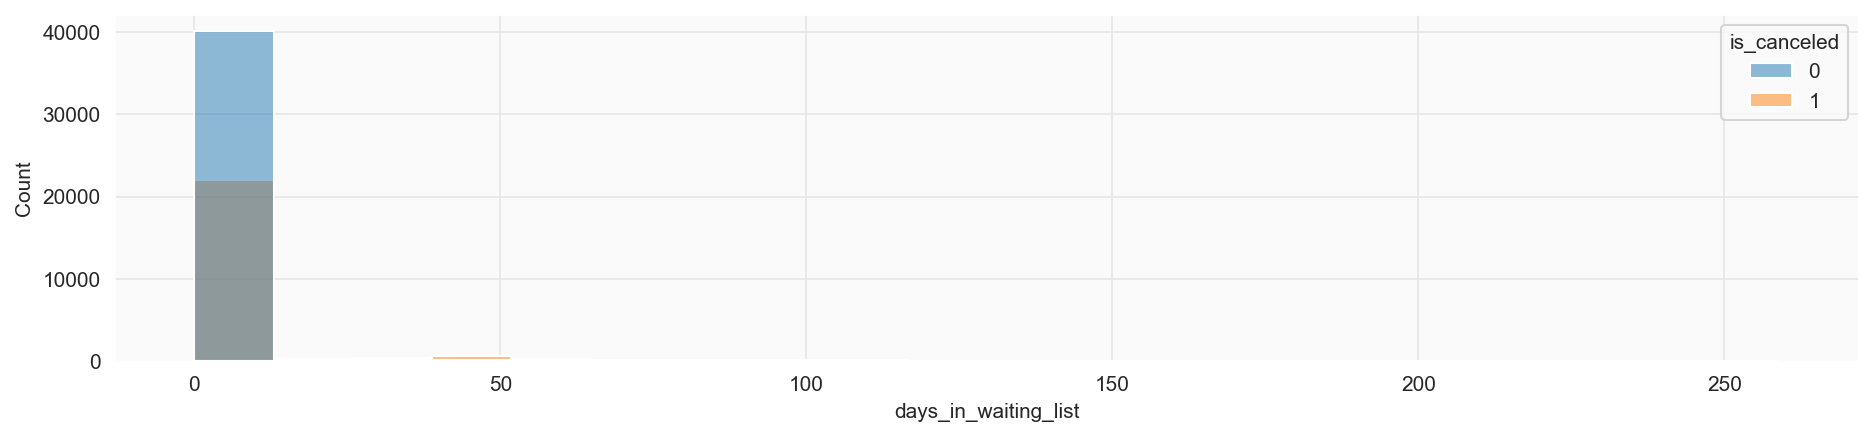

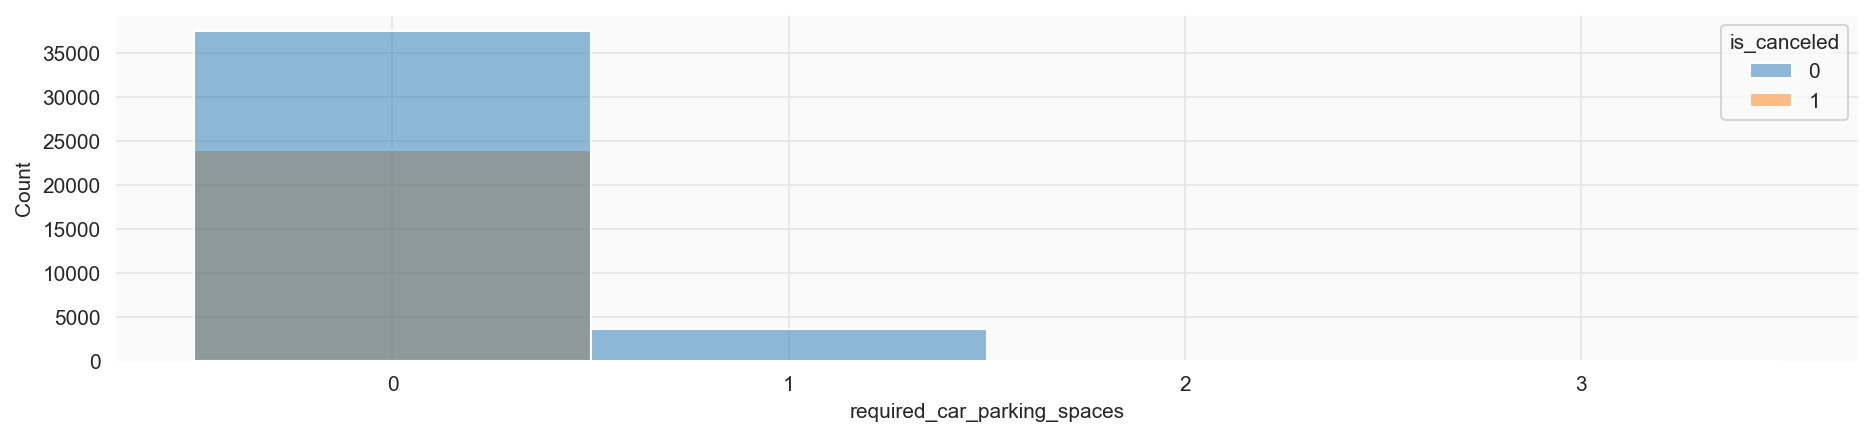

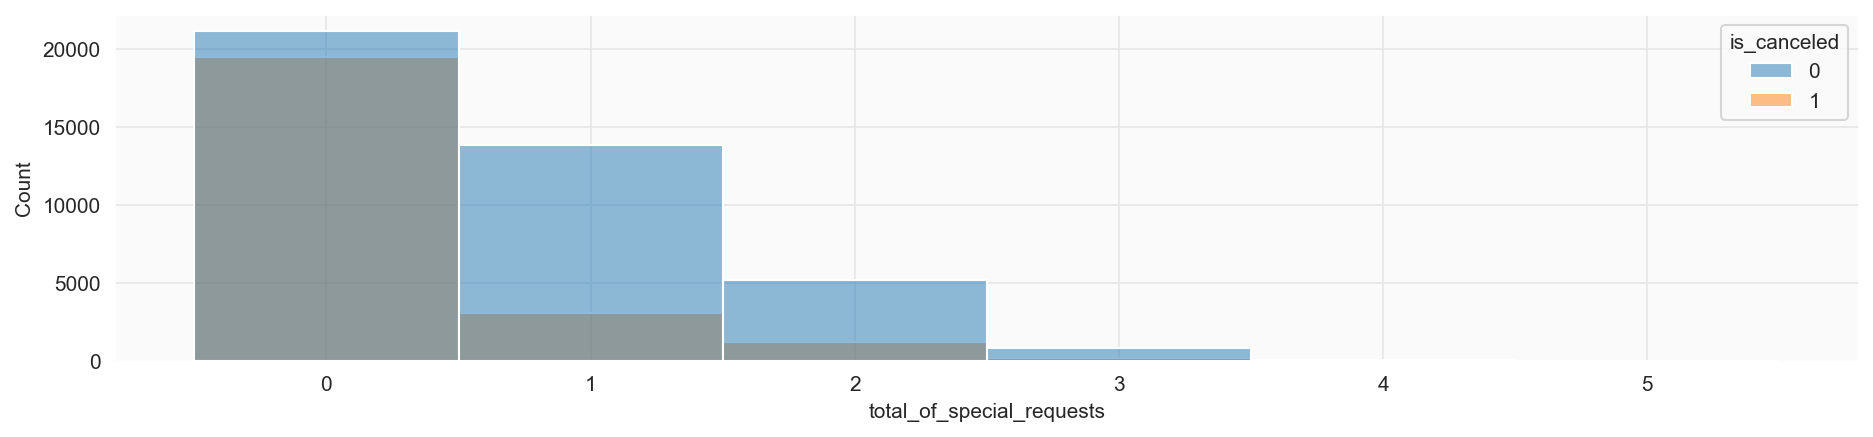

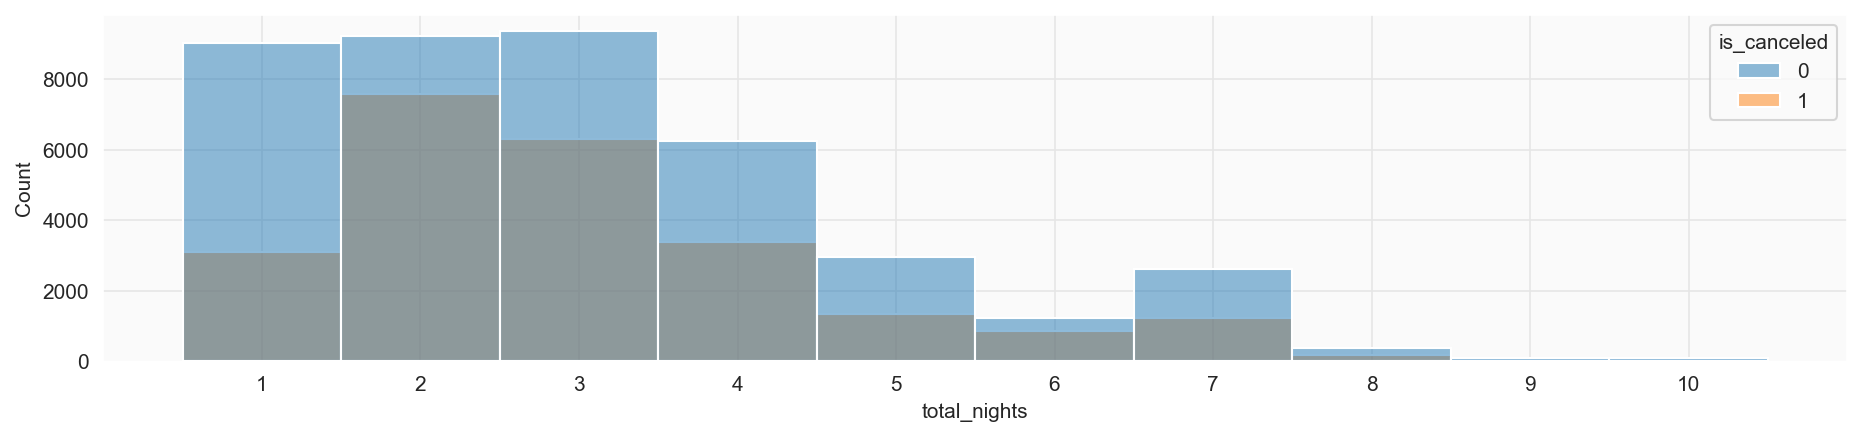

In [24]:
for column in df.drop('is_canceled', axis=1).columns:
    
    # подбор количества корзин для лучшего восприятия
    discrete_ = True if df[column].nunique() < 60 else False
    
    fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
    sns.histplot(x=df[column], hue=df.is_canceled, bins=20, discrete=discrete_)
    
    if df[column].nunique() < 60:
        ax.set_xticks(df[column].unique());

Дополнительные, по-своему показательные графики.  
Закомментировал, чтобы не загромождать проект.

In [25]:
# for column in df.drop('is_canceled', axis=1).columns:
    
#     # подбор количества корзин для лучшего восприятия
#     discrete_ = True if df[column].nunique() < 60 else False
    
#     fig, ax = plt.subplots(figsize=(15,3), dpi=plot_dpi)
#     sns.histplot(x=df[column], hue=df.is_canceled, bins=20, discrete=discrete_, multiple='fill')
    
#     if df[column].nunique() < 60:
#         ax.set_xticks(df[column].unique());

> Можно предположить, что на отмену бронирования больше других могут влиять следующие признаки:  
> - `distribution_channel`;  
> - `lead_time`;  
> - `previous_cancellations` (в данных очень мало повторных клиентов, поэтому данное поле может оказаться бесполезным);  
> - `booking_changes`;  
> - `required_car_parking_spaces`;  
> - `total_of_special_requests`.

> Признаки, которые, вероятно, не помогут в обучении модели:
> - `arrival_date_month`;
> - `meal`;
> - `reserved_room_type`;
> - `customer_type`;
> - `arrival_date_year`;
> - `arrival_date_week_number`;
> - `arrival_date_day_of_month`;
> - `stays_in_weekend_nights`;
> - `stays_in_week_nights`;
> - `days_in_waiting_list`;
> - `adults`;
> - `total_nights`.

> Ряд признаков с сильным дисбалансом значений требует дополнительного изучения.

> Некоторые поля (например, месяц) не имеют выраженного влияния на целевой признак, но потребуются для других расчетов.

> По графикам некоторых признаков можно определить наличие выбросов. Все эти признаки далее будут либо исключены, либо преобразованы в бинарные, поэтому отдельно обрабатывать выбросы нет необходимости.

### Исследование признаков — кандидатов на преобразование в бинарные или удаление

Некоторые признаки имеют сильный дисбаланс значений, из-за чего их влияние на модель может быть малозначимым.  
Некоторые признаки, возможно, будут более информативными, если их преобразовать в бинарные.

In [26]:
def check_imbalanced_features(df: pd.DataFrame, field: str):
    '''
    Создает из переданного признака (field) бинарный по принципу равенства либо неравенства нулю.
    На базе созданного бинарного признака считает распределение "отказников" в переданном датафрейме.
    Если переданный признак изначально бинарный, функция все так же работает корректно.
    Функция ничего не возвращает, результат – вывод на экран.
    '''
    
    df['is_' + field] = df[field].apply(lambda x: 0 if x == 0 else 1)
    display(df.groupby([('is_' + field),'is_canceled']).size().unstack().fillna(0).assign(relative = lambda x: x[0]/x[1]))

In [27]:
# список исследуемых признаков с сильным дисбалансом
fields_lst = ['babies','children','is_repeated_guest','previous_bookings_not_canceled','days_in_waiting_list',
              'previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests']

for field in fields_lst:
    check_imbalanced_features(data.copy(), field)

is_canceled,0,1,relative
is_babies,,,
0,40815,23962,1.703
1,370,82,4.512


is_canceled,0,1,relative
is_children,,,
0,38782,22930,1.691
1,2403,1114,2.157


is_canceled,0,1,relative
is_is_repeated_guest,,,
0,39861,23597,1.689
1,1324,447,2.962


is_canceled,0,1,relative
is_previous_bookings_not_canceled,,,
0,39740,23946,1.660
1,1445,98,14.745


is_canceled,0,1,relative
is_days_in_waiting_list,,,
0,40080,21925,1.828
1,1105,2119,0.521


is_canceled,0,1,relative
is_previous_cancellations,,,
0,40943,18648,2.196
1,242,5396,0.045


is_canceled,0,1,relative
is_booking_changes,,,
0,33479,22716,1.474
1,7706,1328,5.803


is_canceled,0,1,relative
is_required_car_parking_spaces,,,
0,37503.000,24044.000,1.560
1,3682.000,0.000,inf


is_canceled,0,1,relative
is_total_of_special_requests,,,
0,21170,19501,1.086
1,20015,4543,4.406


> Почти для всех рассматриваемых в этом пункте признаков характерен существенный дисбаланс значений.

> Клиенты с младенцами гораздо реже отказываются от бронирования, но их количество крайне мало.  
> Можно удалить признак `babies`.
>
> Среди клиентов с детьми и без детей нет явно выраженной тенденции к отказу от бронирования.  
> Можно удалить признак `children`.
>
> Среди повторных клиентов есть тенденция к сохранению бронирования, но их количество крайне мало.  
> Можно удалить признак `is_repeated_guest`.
>
> Доля "отказников" среди клиентов, имеющих неотмененные заказы, значительно ниже, чем в среднем по датасету.  
> Создадим новый признак `is_previous_bookings_not_canceled`.
>
> Среди клиентов, которым пришлось ожидать подтверждения заказа, явно преобладают "отказники", но их количество крайне мало.  
> Можно удалить признак `is_days_in_waiting_list`.
>
> Клиенты, имеющие отказы от бронирования, многократно реже выполняют заказы.  
> Необходимо сохранить признак `is_previous_cancellations`.
>
> Клиенты, вносившие хотя бы одно изменение в заказ, гораздо реже отказываются от бронирования.  
> Создадим новый признак `is_booking_changes`.
>
> Клиенты, заказавшие хотя бы одно парковочное место, никогда не отказываются от бронирования.  
> Создадим новый признак `is_required_car_parking_spaces`.
>
> Клиенты, имеющие хотя бы одно дополнительное требование, гораздо реже отказываются от бронирования.  
> Создадим новый признак `is_total_of_special_requests`.

### Исследование признака `country`

Количество категорий в признаке `country` очень велико. При этом клиенты из ряда стран встречаются редко. Для более продуктивного анализа объединим клиентов из редких стран в одну категорию `OTHER`. Отнесем к ней те страны, из которых было менее 50 клиентов. Такой порог позволит вчетверо сократить число категорий, а сама категория `OTHER` не будет излишне многочисленной.  
Можно поэкспериментировать с порогом для оценки влияния на модель.

In [28]:
# всего разных стран
data.country.value_counts().count()

155

In [29]:
# количество клиентов из одной страны в среднем
print(f'{data.country.value_counts().sum() / data.country.value_counts().count():.0f}')

421


In [30]:
# новый признак с укрупненными категориями (в обучающей и тестовой выборках)

small_qnty_country = data.country.value_counts()[data.country.value_counts() < 50].index.to_list()

data['country_50'] = data.country
data['country_50'] = data.country.mask(data.country.isin(small_qnty_country), 'OTHER')

data_test['country_50'] = data_test.country
data_test['country_50'] = data_test.country.mask(data_test.country.isin(small_qnty_country), 'OTHER')

In [31]:
# всего разных стран после укрупнения категорий
data.country_50.value_counts().count()

40

In [32]:
# распределение "отказников" в признаке country
(
  data
 .groupby(['country_50','is_canceled'])
 .size()
 .unstack()
 .assign(total = lambda x: x[0] + x[1]).astype(int)
 .assign(canceled = lambda x: x[1]/x.total)
 .sort_values('total', ascending=False)
 .head(15)
)

is_canceled,0,1,total,canceled
country_50,,,,
PRT,12227,16604,28831,0.576
FRA,5098,876,5974,0.147
GBR,4171,938,5109,0.184
ESP,3819,1081,4900,0.221
DEU,3346,541,3887,0.139
ITA,1560,767,2327,0.330
IRL,1132,313,1445,0.217
OTHER,879,389,1268,0.307
BEL,1037,208,1245,0.167


> В топ-странах по количеству клиентов доля "отказников" ощутимо ниже средней – 37%.  
> Кроме одной: клиенты из страны `PRT` (Португалия?) намного чаще делают заказы, но и доля отмененных заказов намного выше.

> Признак `country_50` с учетом укрупнения категорий может оказаться значимым для модели.

## Создание новых признаков

В обучающей и тестовой выборках.

### Бинарные признаки

In [33]:
def add_binary_feature(df: pd.DataFrame, field: str):
    '''
    Создает из переданного признака (field) бинарный по принципу равенства либо неравенства нулю.
    На базе созданного бинарного признака считает распределение "отказников" в переданном датафрейме.
    Если переданный признак изначально бинарный, функция все так же работает корректно.
    '''
    
    df['is_' + field] = df[field].apply(lambda x: 0 if x == 0 else 1)
    
    return df

In [34]:
# список признаков, на основе которых необходимо создать бинарные признаки
feature_lst = ['previous_bookings_not_canceled',  # наличие неотмененных заказов
               'booking_changes',                 # вносил ли клиент изменения в заказ
               'required_car_parking_spaces',     # нужно ли клиенту парковочное место для автомобиля
               'total_of_special_requests',       # указал ли клиент дополнительные требования в заказе
              ]

for feature in feature_lst:
    data = add_binary_feature(data, feature)
    data_test = add_binary_feature(data_test, feature)

### Базовая стоимость аренды комнаты

Без учета сезонности.

In [35]:
data['base_room_price'] = np.select(
                                    [data.reserved_room_type == "A",
                                     data.reserved_room_type == "B",
                                     data.reserved_room_type == "C",
                                     data.reserved_room_type == "D",
                                     data.reserved_room_type == "E",
                                     data.reserved_room_type == "F",
                                     data.reserved_room_type == "G"],
                                    [1000, 800, 600, 550, 500, 450, 350]
                                   )

data_test['base_room_price'] = np.select(
                                    [data_test.reserved_room_type == "A",
                                     data_test.reserved_room_type == "B",
                                     data_test.reserved_room_type == "C",
                                     data_test.reserved_room_type == "D",
                                     data_test.reserved_room_type == "E",
                                     data_test.reserved_room_type == "F",
                                     data_test.reserved_room_type == "G"],
                                    [1000, 800, 600, 550, 500, 450, 350]
                                   )

### Сезонная стоимость аренды комнаты

Стоимость с учетом повышающего сезонного коэффициента.

In [36]:
SPRING_AUTUMN = ['March','April','May','September','October','November']
SUMMER = ['June','July','August']
WINTER = ['December','January','February']

SPRING_AUTUMN_COEFF = 1.2
SUMMER_COEFF = 1.4

data['season_room_price'] = np.select(
                                      [data.arrival_date_month.isin(WINTER),
                                       data.arrival_date_month.isin(SPRING_AUTUMN),
                                       data.arrival_date_month.isin(SUMMER)],
                                      [data.base_room_price,
                                       data.base_room_price * SPRING_AUTUMN_COEFF,
                                       data.base_room_price * SUMMER_COEFF]
                                     ).astype(int)

data_test['season_room_price'] = np.select(
                                      [data_test.arrival_date_month.isin(WINTER),
                                       data_test.arrival_date_month.isin(SPRING_AUTUMN),
                                       data_test.arrival_date_month.isin(SUMMER)],
                                      [data_test.base_room_price,
                                       data_test.base_room_price * SPRING_AUTUMN_COEFF,
                                       data_test.base_room_price * SUMMER_COEFF]
                                     ).astype(int)

### Стоимость подготовки / уборки комнаты

In [37]:
data['room_service_price'] = np.select(
                                      [data.reserved_room_type == "A",
                                       data.reserved_room_type.isin(["B", "C"]),
                                       data.reserved_room_type.isin(["D", "E", "F", "G"])],
                                      [400, 350, 150]
                                     )

data_test['room_service_price'] = np.select(
                                      [data_test.reserved_room_type == "A",
                                       data_test.reserved_room_type.isin(["B", "C"]),
                                       data_test.reserved_room_type.isin(["D", "E", "F", "G"])],
                                      [400, 350, 150]
                                     )

## Прибыль до внедрения депозитов

Образец для демонстрации логики расчета количества уборок:

| кол-во ночей | подготовительная уборка | кол-во плановых уборок | всего уборок |
|--------------|-------------------------|------------------------|--------------|
| 1            | 1                       | 0                      | 1            |
| 2            | 1                       | 0                      | 1            |
| 3            | 1                       | 1                      | 2            |
| 4            | 1                       | 1                      | 2            |
| 5            | 1                       | 2                      | 3            |
| 6            | 1                       | 2                      | 3            |

Код для проверки алгоритма расчета количества уборок.

In [38]:
# for i in range(1, 7):
#     print(f'{i}: {(i+1) // 2}')

Расчет потенциальной прибыли для каждого заказа (без учета, выполнен заказ или отменен).

In [39]:
data['potential_profit'] = data.season_room_price * data.total_nights - ((data.total_nights + 1) // 2) * data.room_service_price

data_test['potential_profit'] = data_test.season_room_price * data_test.total_nights - ((data_test.total_nights + 1) // 2) * data_test.room_service_price

Расчет фактической прибыли для каждого заказа (с учетом, выполнен заказ или отменен).

In [40]:
data['profit'] = np.select([data.is_canceled == 0, data.is_canceled == 1],
                           [data.potential_profit,
                            (data.season_room_price + data.room_service_price) * (-1)]
                          )

data_test['profit'] = np.select([data_test.is_canceled == 0, data_test.is_canceled == 1],
                                [data_test.potential_profit,
                                 (data_test.season_room_price + data_test.room_service_price) * (-1)]
                               )

Образец для проверки: можно проверить расчет прибыли, начиная с выбора типа комнаты.

In [41]:
data[['is_canceled','reserved_room_type','arrival_date_month','total_nights',
      'season_room_price','room_service_price','potential_profit','profit']].sample()

,is_canceled,reserved_room_type,arrival_date_month,total_nights,season_room_price,room_service_price,potential_profit,profit
4895,1,E,September,10,600,150,5250,-750


Суммарная прибыль за период, соответствующий входным данным.

In [42]:
print(f'{CR}Суммарная прибыль для обучающего набора: {f.BOLD}{data.profit.sum() / 1e6}{f.END} млн.руб.')
print(f'{CR}Суммарная прибыль для тестового набора: {f.BOLD}{data_test.profit.sum() / 1e6}{f.END} млн.руб.{CR}')


Суммарная прибыль для обучающего набора: 72.02792 млн.руб.

Суммарная прибыль для тестового набора: 35.300731 млн.руб.



Определение продолжительности периода входных данных.

In [43]:
# для обучающего набора
pd.to_datetime(
               data.arrival_date_year.astype(str) + '/' + 
               data.arrival_date_month.astype(str) + '/' + 
               data.arrival_date_day_of_month.astype(str)
              ).agg(['min','max'])

min   2015-07-01
max   2016-12-31
dtype: datetime64[ns]

In [44]:
# для тестового набора
pd.to_datetime(
               data_test.arrival_date_year.astype(str) + '/' + 
               data_test.arrival_date_month.astype(str) + '/' + 
               data_test.arrival_date_day_of_month.astype(str)
              ).agg(['min','max'])

min   2017-01-01
max   2017-08-31
dtype: datetime64[ns]

Суммарная прибыль в пересчете на один год (исходя из простого усреднения по месяцам).

In [45]:
print(f'{CR}Предполагаемая годовая прибыль для обучающего набора: {f.BOLD}{data.profit.sum() / 1e6 / 18*12 :.3f}{f.END} млн.руб.')
print(f'{CR}Предполагаемая годовая прибыль для тестового набора: {f.BOLD}{data_test.profit.sum() / 1e6 / 8*12 :.3f}{f.END} млн.руб.{CR}')


Предполагаемая годовая прибыль для обучающего набора: 48.019 млн.руб.

Предполагаемая годовая прибыль для тестового набора: 52.951 млн.руб.



> Прибыль до внедрения депозита на тестовом наборе составила 35.3 млн.руб. за 8 месяцев или 52.95 млн.руб. в пересчете на полный год.

> В прогнозе на полный 2017 год использовано простое помесячное усреднение. Для более точного прогноза можно рассчитать прибыль в зависимости от месяца, опираясь на предыдущий полный год.

## Корреляция

Исследована здесь, а не на этапе EDA, чтобы оценить силу связи между потенциальной прибылью `potential_profit` и отменой заказа (спойлер: связь почти отсутствует).

Корреляция оценивается по модулю, поскольку направление в данном случае неважно.

### Корреляция признаков с целевой переменной

In [46]:
data.corr('spearman').is_canceled.to_frame().drop('is_canceled').abs().sort_values('is_canceled', ascending=False)

,is_canceled
profit,0.838
previous_cancellations,0.374
lead_time,0.338
is_total_of_special_requests,0.296
total_of_special_requests,0.287
is_required_car_parking_spaces,0.187
required_car_parking_spaces,0.187
is_booking_changes,0.184
booking_changes,0.183
days_in_waiting_list,0.135


### Корреляция признаков между собой

Только значения больше 0.3

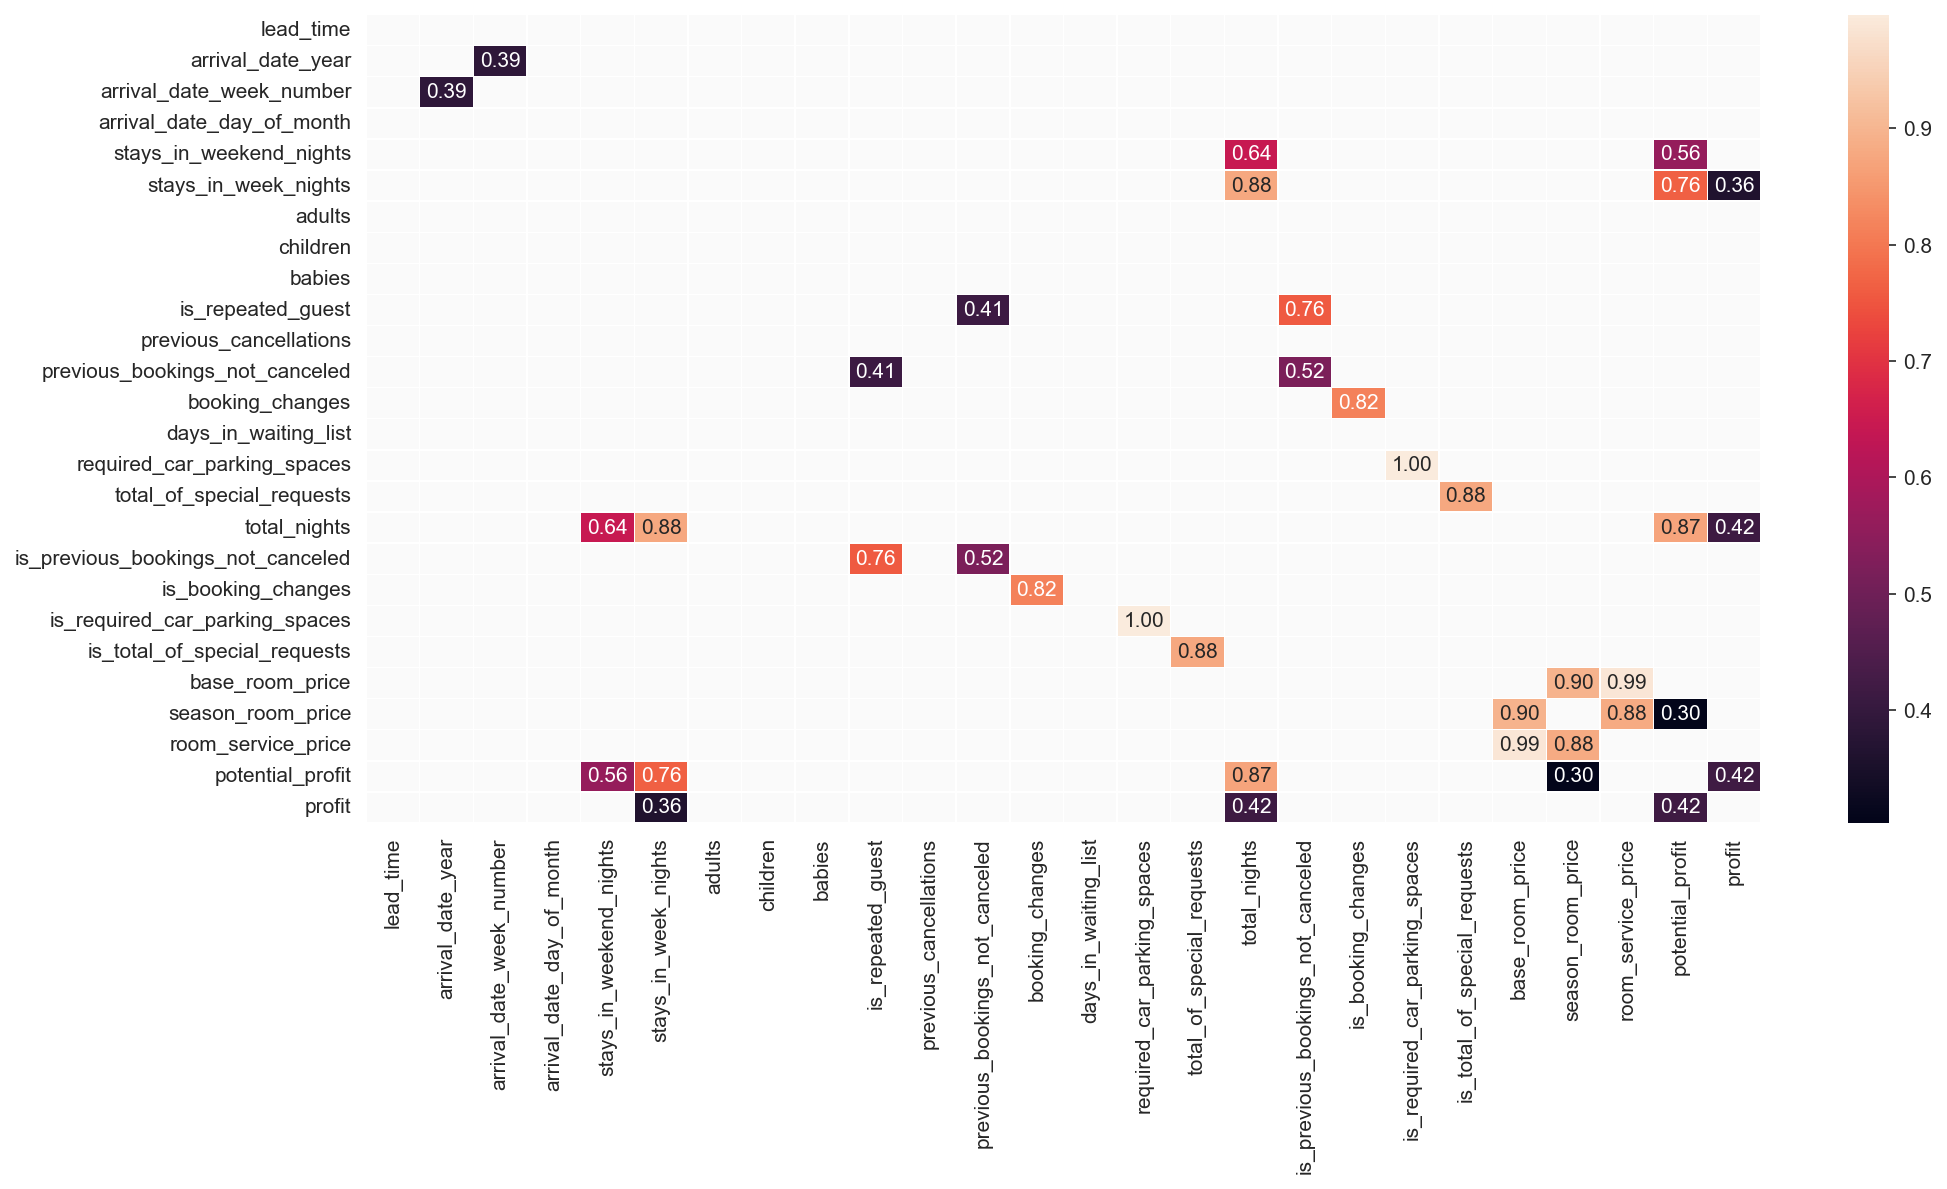

In [47]:
fig, ax = plt.subplots(figsize=(15,7), dpi=plot_dpi)
df = data.drop('is_canceled', axis=1).corr().abs()
sns.heatmap(df[(1 > df) & (df > 0.3)], annot=True, fmt='.2f', linewidths=0.2);

> Среди числовых признаков ни один не имеет выраженной кореляции с целевым признаком.  
> В целом, корреляция подтверждает предварительные выводы об исключении некоторых признаков и преобразовании ряда других в бинарные.

> Сильная корреляция между некоторыми признаками будет учтена на этапе выбора признаков и алгоритма для модели.

## Разработка модели ML

### Выбор метрики для оптимизации моделей

Для того, чтобы получить максимальную прибыль, отель предполагает брать депозит у потенциальных "отказников". Напрашивается решение – брать депозит со всех клиентов, тогда ни один отказник не ускользнет. Но, видимо, где-то в недрах маркетингового отдела есть информация, что такая политика отпугнет часть клиентов. И здесь наступает самое интересное: из условий задачи **неизвестно, как повлияет депозит на долю отказов.**

Будем исходить из того, что данный проект – только начало пути, и в будущем мы все-таки получим необходимую информацию. Метрика $F_β$ интересна не только тем, что гармонично объединяет метрики `precision` и `recall`, но и коэффициентом β. С его помощью можно регулировать соотношение важности `precision` и `recall`. Можно использовать это, если в будущем получим недостающую информацию от конспираторов-маркетологов.

![F1_score](https://habrastorage.org/getpro/habr/post_images/4f1/f5c/0ab/4f1f5c0ab5dcf8379ff4bcbbd02f0623.svg)

Пока остановимся на оптимизации моделей по метрике `F1`.

### Выделение признаков и целевой переменной

In [48]:
features = [
            'lead_time',
            'previous_cancellations',
            'is_total_of_special_requests',
            'is_required_car_parking_spaces',
            'is_booking_changes',
            'is_previous_bookings_not_canceled',
            'country_50',
            'distribution_channel',
            'customer_type']

X_train = data[features]
Y_train = data.is_canceled

X_test = data_test[features]
Y_test = data_test.is_canceled

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((65229, 9), (65229,), (32412, 9), (32412,))

### Препроцессинг

Подготовка признаков: **масштабирование** для числовых признаков и **one-hot** кодирование для нечисловых.

Балансировка классов поручена встроенным методам моделей (у кого они есть). Применение сторонней балансировки (например, SVMSMOTE) катастрофически снижает скорость обучения.

In [49]:
# FPP - features pre-processing

step_FPP = ('FPP', ColumnTransformer([
                                      # для числовых признаков
                                      ('num', make_pipeline(StandardScaler()),
                                                            make_column_selector(dtype_include=['number'])
                                      ),
                                      # для категориальных признаков
                                      ('obj', make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore')),
                                                            make_column_selector(dtype_exclude=['number'])
                                      )
                                     ])
           )

### Пайплайны моделей

In [50]:
pipelines_list = [Pipeline([ step_FPP, ('DC',  DummyClassifier(random_state=RS)) ]),
                  Pipeline([ step_FPP, ('RFC', RandomForestClassifier(random_state=RS)) ]),
                  Pipeline([ step_FPP, ('HGBC', HistGradientBoostingClassifier(random_state=RS)) ]),
                  Pipeline([ step_FPP, ('SGDC', SGDClassifier(random_state=RS)) ]),
                  Pipeline([ step_FPP, ('LSVC', LinearSVC(dual=False, random_state=RS)) ]),
                 ]

names_list = ['baseline: DummyClassifier', 'RandomForestClassifier',
              'HistGradientBoostingClassifier', 'SGDClassifier', 'LinearSVC']

short_names_list = ['DC', 'RFC', 'HGBC', 'SGDC', 'LSVC']

### Объединение всех данных о моделях в датафрейм

Для удобства контроля и обработки результата.

In [51]:
models = pd.DataFrame(data={'name': names_list,
                            'short_name': short_names_list,
                            'model': pipelines_list,
                           },
                     )
models

,name,short_name,model
0,baseline: DummyClassifier,DC,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('sta..."
1,RandomForestClassifier,RFC,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('sta..."
2,HistGradientBoostingClassifier,HGBC,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('sta..."
3,SGDClassifier,SGDC,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('sta..."
4,LinearSVC,LSVC,"(ColumnTransformer(transformers=[('num',\n Pipeline(steps=[('sta..."


### Objective function для Optuna

In [52]:
def objective_DC(trial):

    params = {'DC__strategy': trial.suggest_categorical('DC__strategy', ['most_frequent', 'prior','stratified','uniform'])}
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

In [53]:
def objective_RFC(trial):

    params = {
              'RFC__n_estimators': trial.suggest_int('RFC__n_estimators', 50, 1000, log=True),
              'RFC__max_depth': trial.suggest_int('RFC__max_depth', 1, 50),
              'RFC__class_weight': trial.suggest_categorical('RFC__class_weight', ['balanced', 'balanced_subsample', None]),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

In [54]:
def objective_HGBC(trial):

    params = {
              'HGBC__max_depth': trial.suggest_int('HGBC__max_depth', 10, 100),
              'HGBC__learning_rate': trial.suggest_float('HGBC__learning_rate', 0.1, 10.0, log=True),
              'HGBC__max_iter': trial.suggest_int('HGBC__max_iter', 10, 500, log=True),
              'HGBC__l2_regularization': trial.suggest_float('HGBC__l2_regularization', 0.001, 1000),
              'HGBC__max_bins': trial.suggest_int('HGBC__max_bins', 5, 255),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

In [55]:
def objective_SGDC(trial):

    params = {
              'SGDC__loss': trial.suggest_categorical('SGDC__loss', ['hinge','log_loss','modified_huber','squared_hinge','perceptron']),
              'SGDC__penalty': trial.suggest_categorical('SGDC__penalty', ['l1', 'l2', 'elasticnet']),
              'SGDC__max_iter': trial.suggest_int('SGDC__max_iter', 5, 1000, log=True),
              'SGDC__validation_fraction': trial.suggest_float('SGDC__validation_fraction', 0.001, 0.999999),
              'SGDC__class_weight': trial.suggest_categorical('SGDC__class_weight', ['balanced', None]),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

In [56]:
def objective_LSVC(trial):

    params = {
              'LSVC__penalty': trial.suggest_categorical('LSVC__penalty', ['l1', 'l2']),
              'LSVC__max_iter': trial.suggest_int('LSVC__max_iter', 10, 1000, log=True),
              'LSVC__C': trial.suggest_float('LSVC__C', 0.01, 100, log=True),
              'LSVC__class_weight': trial.suggest_categorical('LSVC__class_weight', ['balanced', None]),
             }
    model.set_params(**params)
    cv_SKF = StratifiedKFold(n_splits=5)
    
    return cross_val_score(model, X_train, Y_train, scoring=SCORING, cv=cv_SKF, n_jobs=-1).mean()

### Подбор гиперпараметров

In [57]:
for item in range(models.shape[0]):
    
    model = models.loc[item,'model']
    
    # создание объекта optuna.study
    study = optuna.create_study(
                                study_name=models.loc[item,'name'],
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=RS)
                               )

    # оптимизация (подбор гиперпараметров)
    if models.loc[item,'short_name'] == 'DC':
        study.optimize(objective_DC, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'RFC':
        study.optimize(objective_RFC, n_trials=N_TRIALS//4, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'HGBC':
        study.optimize(objective_HGBC, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'SGDC':
        study.optimize(objective_SGDC, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)
    elif models.loc[item,'short_name'] == 'LSVC':
        study.optimize(objective_LSVC, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True, n_jobs=-1)

    # извлечение и обучение лучшей модели
    model.set_params(**study.best_params).fit(X_train, Y_train)

    # сохранение результатов в таблице моделей
    models.loc[item,'model'] = model
    models.loc[item,'study'] = study
    
    print(f'{CR}{f.BOLD}{study.study_name}{f.END}{CR}')
    print(f'Количество попыток: {len(study.trials)}')
    print(f'Лучший результат: {f.BOLD}{study.best_value:0.4f}{f.END}{CR}')
    print('Комбинация гиперпараметров:')
    print(json.dumps(study.best_params, indent=1, sort_keys=True), f'{CR}')

  0%|          | 0/200 [00:00<?, ?it/s]


baseline: DummyClassifier

Количество попыток: 200
Лучший результат: 0.4297

Комбинация гиперпараметров:
{
 "DC__strategy": "uniform"
} 



  0%|          | 0/50 [00:00<?, ?it/s]


RandomForestClassifier

Количество попыток: 50
Лучший результат: 0.6850

Комбинация гиперпараметров:
{
 "RFC__class_weight": "balanced_subsample",
 "RFC__max_depth": 12,
 "RFC__n_estimators": 318
} 



  0%|          | 0/200 [00:00<?, ?it/s]


HistGradientBoostingClassifier

Количество попыток: 118
Лучший результат: 0.6884

Комбинация гиперпараметров:
{
 "HGBC__l2_regularization": 787.383314396007,
 "HGBC__learning_rate": 0.44929338228984184,
 "HGBC__max_bins": 25,
 "HGBC__max_depth": 44,
 "HGBC__max_iter": 107
} 



  0%|          | 0/200 [00:00<?, ?it/s]


SGDClassifier

Количество попыток: 200
Лучший результат: 0.7089

Комбинация гиперпараметров:
{
 "SGDC__class_weight": "balanced",
 "SGDC__loss": "modified_huber",
 "SGDC__max_iter": 10,
 "SGDC__penalty": "l2",
 "SGDC__validation_fraction": 0.16397481673228284
} 



  0%|          | 0/200 [00:00<?, ?it/s]


LinearSVC

Количество попыток: 182
Лучший результат: 0.6892

Комбинация гиперпараметров:
{
 "LSVC__C": 0.039675229303640584,
 "LSVC__class_weight": "balanced",
 "LSVC__max_iter": 150,
 "LSVC__penalty": "l1"
} 



### Визуализация результатов подбора гиперпараметров

Помогает cкорректировать процесс подбора.

In [58]:
# for item in range(models.shape[0]):
#     plot_Optuna(models.loc[item,'study'], 'plot_slice', models.loc[item, 'name'])
# #     plot_Optuna(models.loc[item,'study'], 'plot_param_importances', models.loc[item, 'name'])     # может работать долго !
# #     plot_Optuna(models.loc[item,'study'], 'plot_optimization_history', models.loc[item, 'name'])

### Лучшая модель

In [59]:
BEST_MODEL_NAME = 'SGDClassifier'

model = models.model.values[models.name == BEST_MODEL_NAME][0]

> По результатам валидации самое высокое значение метрики `F1` у модели `SGDClassifier`.

### Функция для сравнения дополнительных метрик

In [60]:
def add_model_metrics(models, X_train, Y_train, X_test, Y_test, cv=5, scoring_list=['f1']):
    '''
    Принимает датафрейм со списком моделей и их характеристиками.
    Добавляет в принятый датафрейм несколько метрик.
    
    :models: датафрейм с информацией об обученных моделях
    :X_train: обучающая выборка (признаки)
    :Y_train: обучающая выборка (целевая переменная)
    :X_test: тестовая выборка (признаки)
    :Y_test: тестовая выборка (целевая переменная)
    :scoring: метрики для оценки
    '''

    for scoring in scoring_list:
    
        # результаты моделей на обучающей выборке (усреднение на кроссвалидации)
        models[scoring + '_valid'] = models.model.apply(
                              lambda model: cross_val_score(model, X_train, Y_train, scoring=scoring, cv=cv, n_jobs=-1).mean())

        # результаты моделей на тестовой выборке (усреднение на кроссвалидации)
        models[scoring + '_test'] = models.model.apply(
                              lambda model: cross_val_score(model, X_test, Y_test, scoring=scoring, cv=cv, n_jobs=-1).mean())
    
    # ROC_AUC, коэффициент корреляции Мэтьюса, коэффициент каппа Коэна
    models['ROC_AUC'] = models.model.apply(lambda model: roc_auc_score(Y_test, model.predict(X_test)))
    models['matthews_coeff'] = models.model.apply(lambda model: matthews_corrcoef(Y_test, model.predict(X_test)))
    models['cohen_kappa'] = models.model.apply(lambda model: cohen_kappa_score(Y_test, model.predict(X_test)))
    
    # оптимальные гиперпараметры
    models['best_params'] = models.study.apply(lambda model: model.best_params)
    
    return models

### Сравнение моделей

Проверим выбранную модель, оценив дополнительные метрики.  
Заодно проверим остальные модели на большем количестве метрик.

In [61]:
models = add_model_metrics(models, X_train, Y_train, X_test, Y_test, cv=5, scoring_list=['f1','accuracy','recall'])

models.drop(['short_name','model','study','best_params'], axis=1)

,name,f1_valid,f1_test,accuracy_valid,accuracy_test,recall_valid,recall_test,ROC_AUC,matthews_coeff,cohen_kappa
0,baseline: DummyClassifier,0.430,0.447,0.504,0.504,0.506,0.517,0.500,0.001,0.001
1,RandomForestClassifier,0.685,0.674,0.773,0.731,0.690,0.722,0.744,0.500,0.498
2,HistGradientBoostingClassifier,0.688,0.657,0.798,0.758,0.634,0.605,0.726,0.505,0.483
3,SGDClassifier,0.709,0.686,0.765,0.743,0.783,0.723,0.733,0.459,0.458
4,LinearSVC,0.689,0.671,0.761,0.725,0.729,0.723,0.735,0.476,0.476


Копия результата (на всякий случай)

|                           name | f1_valid | f1_test | accuracy_valid | accuracy_test | recall_valid | recall_test | ROC_AUC | matthews_coeff | cohen_kappa |
|-------------------------------:|---------:|--------:|---------------:|--------------:|-------------:|------------:|--------:|---------------:|------------:|
| baseline: DummyClassifier      | 0.430    | 0.447   | 0.504          | 0.504         | 0.506        | 0.517       | 0.500   | 0.001          | 0.001       |
| RandomForestClassifier         | 0.685    | 0.674   | 0.773          | 0.731         | 0.690        | 0.722       | 0.744   | 0.500          | 0.498       |
| HistGradientBoostingClassifier | 0.688    | 0.657   | 0.798          | 0.758         | 0.634        | 0.605       | 0.726   | 0.505          | 0.483       |
| SGDClassifier                  | 0.709    | 0.686   | 0.765          | 0.743         | 0.783        | 0.723       | 0.733   | 0.459          | 0.458       |
| LinearSVC                      | 0.689    | 0.671   | 0.761          | 0.725         | 0.729        | 0.723       | 0.735   | 0.476          | 0.476       |

> На тестовой выборке метрика `F1` всех моделей несколько снизилась. Дополнительные метрики достаточно высоки, чтобы подтвердить правильный выбор модели.

> В целом, все модели показали себя неплохо, и при некоторой доработке могли бы претендовать на выбор. Но в этом проекте выбор уже сделан ))

### Важность признаков

Для выбранной модели.

#### Функция для визуализации важности признаков

In [62]:
def plot_feature_importances(model_name, feature_names, feature_importances):
    """
    Выводит график важности признаков, использованных моделью.
    
    :model_name: название модели
    :feature_names: названия признаков
    :feature_importances: важность признаков
    """
    
    fig, ax = plt.subplots(figsize=(15,5), dpi=plot_dpi)

    df = pd.DataFrame({'features': feature_names,
                       'importances': feature_importances.importances_mean,
                       'std_err': feature_importances.importances_std,
                      }).sort_values('importances', ascending=False)
    
    sns.barplot(
                x=df.importances,
                y=df.features,
                xerr=df.std_err,
                color='skyblue',
               )
    
    ax.set_title(f'{model_name}: permutation importance', fontsize=18, pad=20)

#### Важность признаков для обучающей выборки

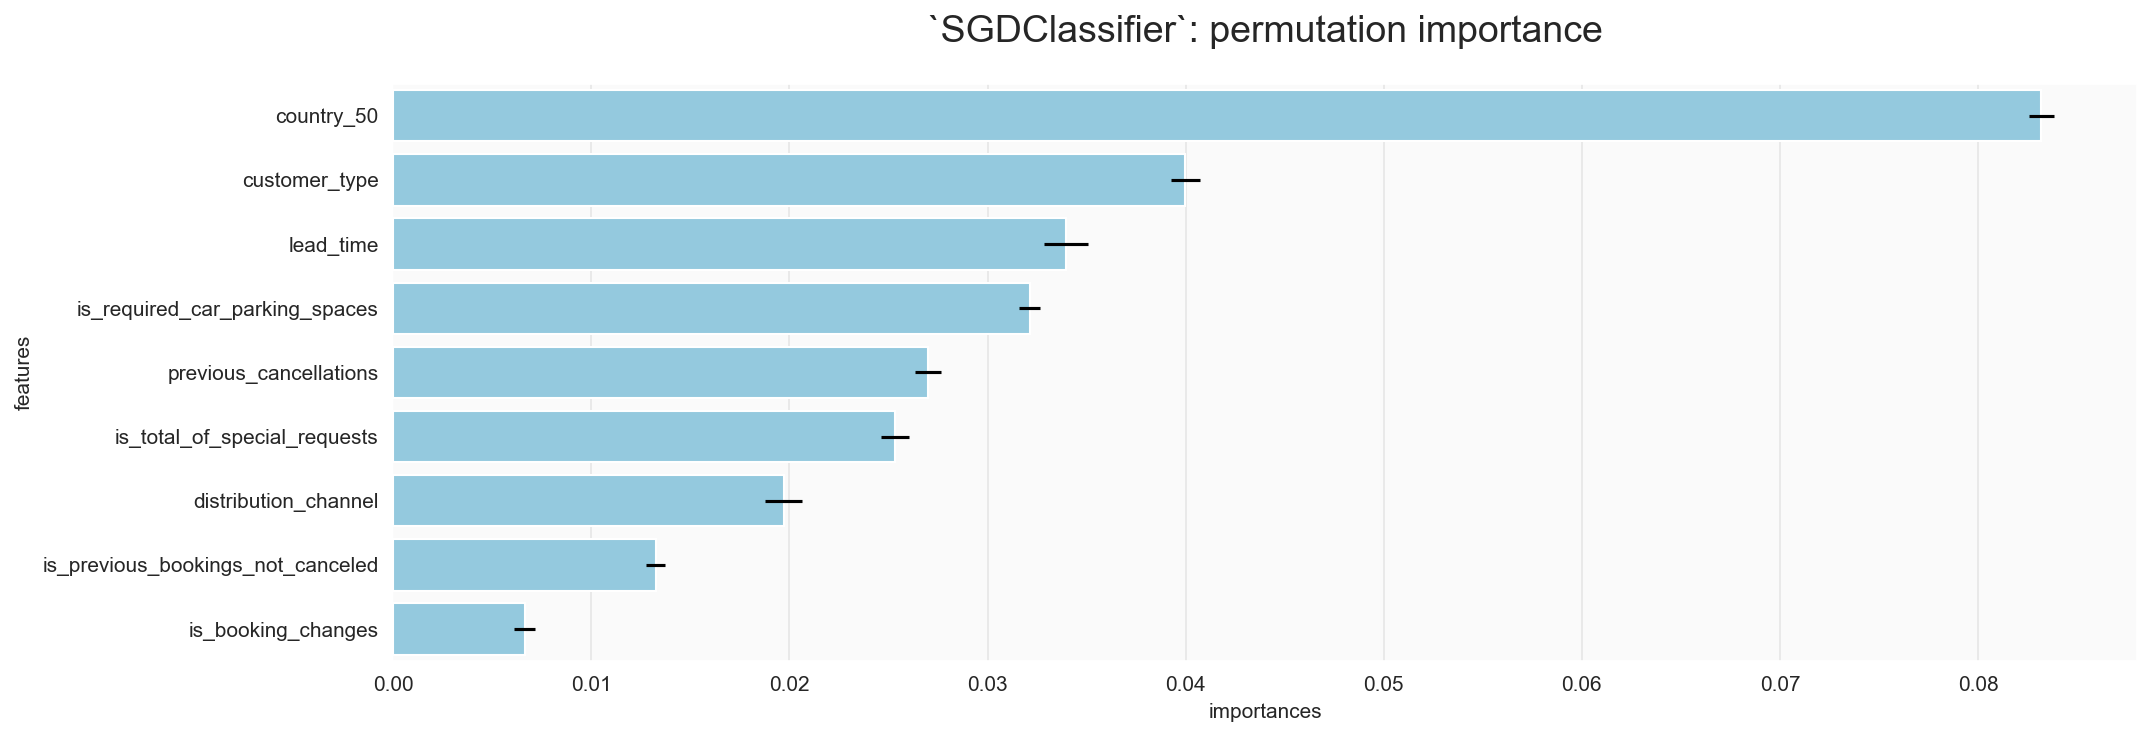

In [63]:
plot_feature_importances(
                         '`SGDClassifier`',
                         # извлечение списка признаков
                         model.feature_names_in_,
                         # вычисление важности признаков
                         permutation_importance(model, X_train, Y_train,
                                                scoring=SCORING, n_repeats=10, n_jobs=-1, random_state=RS)
                        )

#### Важность признаков для тестовой выборки

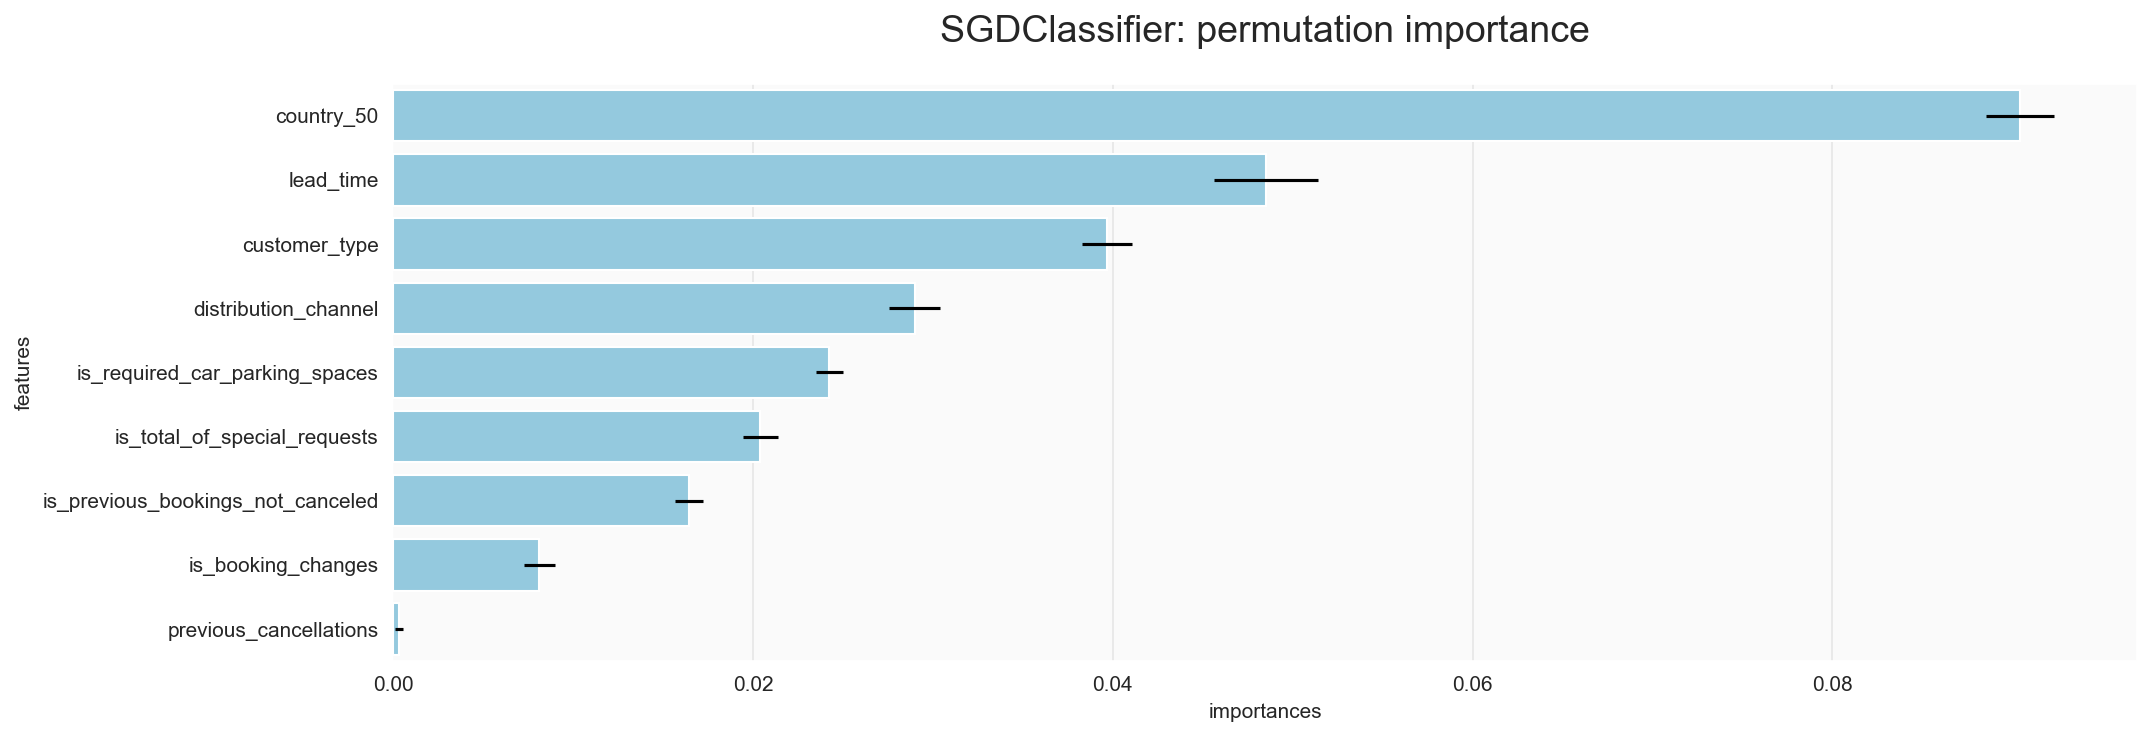

In [64]:
plot_feature_importances(
                         'SGDClassifier',
                         # извлечение списка признаков
                         model.feature_names_in_,
                         # вычисление важности признаков
                         permutation_importance(model, X_test, Y_test,
                                                scoring=SCORING, n_repeats=10, n_jobs=-1, random_state=RS)
                        )

> На первый взгляд, признак `previous_cancellations` значим, но без него качество модели практически не меняется. Кроме того, на тестовом наборе значимость этого признака околонулевая. Вероятно, это связано с тем, что у отеля слишком мала доля повторных клиентов. Можно оставить этот признак в расчете, что со временем доля повторных клиентов увеличится.

> Самым значимым признаком оказался `country_50` (производный от `country` с укрупнением категорий). Можно поэкспериментировать с порогом, ниже которого страны относятся к категории `OTHER`.

## Прибыль от внедрения модели

Модель приносит прибыль, когда с клиента, в итоге отменившего заказ, взымается депозит.

In [65]:
DEPOSIT_COEFF = 0.8     # коэффициент для расчета депозита
DEVELOP_COST = 400e3    # стоимость разработки системы прогнозирования

In [66]:
data_test['predicted'] = model.predict(X_test)

In [67]:
data_test['deposit_profit'] = np.select([data_test.is_canceled != data_test.predicted,
                                         data_test.is_canceled + data_test.predicted == 2],
                                        [0, (data_test.season_room_price + data_test.room_service_price) * DEPOSIT_COEFF]
                                       )

In [68]:
data_test[['is_canceled','predicted','season_room_price','room_service_price','deposit_profit']].sample(5)

,is_canceled,predicted,season_room_price,room_service_price,deposit_profit
26633,0,0,1200,400,0.000
29236,0,1,1400,400,0.000
14616,1,0,1400,400,0.000
5204,0,0,660,150,0.000
23853,0,0,1200,400,0.000


In [69]:
print(f'{CR}Прибыль, ожидаемая от внедрения модели:')
print(f' - за 8 месяцев тестовых данных:  {(data_test.deposit_profit.sum() - DEVELOP_COST) / 1e6 :.3f} млн.руб')
print(f' - за 2017 год (расчетно):        {(data_test.deposit_profit.sum() * 1.5 - DEVELOP_COST) / 1e6 :.3f} млн.руб')


Прибыль, ожидаемая от внедрения модели:
 - за 8 месяцев тестовых данных:  10.043 млн.руб
 - за 2017 год (расчетно):        15.265 млн.руб


> Предполагаемая от внедрения модели прибыль за тестовый период во много раз превысила бы затраты на разработку.

> В прогнозе на полный 2017 год использовано простое помесячное усреднение. Для более точного прогноза можно рассчитать прибыль в зависимости от месяца, опираясь на предыдущий полный год.

## Признаки клиента, повышающие вероятность отмены заказа

**country**  
Клиенты из Португалии делают отказы значительно чаще. К тому же, клиентов из этой страны больше всего.

**distribution_channel = 'TA/TO'**  
Клиент сделал заказ через туроператора/турагентство. Возможно, так туроператоры cтрахуются, делая заказ в нескольких отелях. Либо им попались неопределившиеся клиенты (см. `previous_cancellations`).

**previous_cancellations > 0**  
Если клиент отменял заказы раньше, это повышает вероятность отказа в будущем. Возможно, у человека часто меняются обстоятельства или он страхуется, как туроператор. Либо просто характер такой.

**lead_time**  
Чем заблаговременнее клиент делает заказ, тем выше вероятность отказа. За время ожидания обстоятельства могут измениться.

**days_in_waiting_list > 0**  
Если клиенту приходится ждать подтверждение заказа от отеля, вероятность отказа растет. Никто не любит, а иногда и не может ждать.

> Здесь учтены только признаки, повышающие вероятность отказа.  
> Признаки снижающие вероятность отказа не учитываются.  
> Например, требование парковки снижает вероятность отказа, но это не означает, что отсутствие такого требования — признак склонности к отказу.

## Вывод

### Краткий обзор проведенной работы

1. Выполнена проверка входных данных и незначительная их правка.
1. Выполнен исследовательский анализ данных.
1. Оценена прибыль отеля до внедрения депозитов.
1. Выбрана метрика для обучения моделей.
1. Обучены несколько моделей, оценено их качество на кросс-валидации.
1. Выбрана лучшая модель, которая затем проверена на тестовой выборке.
1. Оценена прибыль, которую принесет выбранная модель.
1. На основе исследовательского анализа выявлены признаки клиента, склонного к отмене заказа.

### Основная часть

#### Исследовательский анализ

Выявлен умеренный дисбаланс классов.  
Изучено распределение признаков в зависимости от значения целевой переменной.  
Исследована целесообразность преобразования ряда признаков в бинарные.  
Отдельно изучен признак `country` с целью укрупнения категорий.  
Изучена корреляция признаков друг с другом и целевой переменной.  
Описаны признаки клиента, повышающие вероятность отмены заказа.

#### Прибыль

Рассчитана прибыль до внедрения депозитов.

#### Подготовка данных для моделей

Созданы дополнительные признаки.  
Ряд признаков исключен.  
Выделена целевая переменная и признаки.  
Для раздельной обработки числовых и категориальных признаков создан пайплайн:  
    - числовые признаки будут обработаны алгоритмом StandardScaler();  
    - нечисловые признаки будут обработаны алгоритмом OneHotEncoder().

#### Обучение моделей и выбор лучшей.

В качестве основной метрики выбрана `F1`. По ней подбирались гиперпараметры модели и выбор лучшей среди них. Дополнительные метрики `accuracy`, `recall`, `ROC-AUC`, `коэффициент корреляции Мэтьюса` и `каппа Коэна` помогли убедиться в правильности выбора модели и отсутствии переобучения.  
Выполнен подбор оптимальных гиперпараметров.  
Выполнено сравнение результатов моделей на кроссвалидации и выбрана лучшая модель.  

#### Финальная модель

На тестовой выборке наблюдается некоторое снижение метрик. Впрочем, не слишком большое, чтобы уверенно говорить о переобучении.  
На финальной модели изучена степень влияния признаков, как на обучающем наборе, так и на тестовом. По некоторым признакам сделаны дополнительные выводы.

#### Прибыль

Рассчитана предполагаемая прибыль от внедрения депозитов.

### Рекомендации и риски
 
Корреляция признаков с целевой переменной низкая. Возможно, данных признаков недостаточно для повышения качества моделей. Либо с имеющимися признаками необходимо провести дополнительную работу.

Неизвестно, в какой момент клиенту будет предложено внести депозит. Если до того, как клиент сможет внести какие-либо изменения в заказ, то признак `is_booking_changes` не успеет сформироваться. В этом случае необходимо исключить его из модели.

Если предложить клиенту депозит, это не означает, что он его оплатит. Поэтому результат от внедрения модели может отличаться как в меньшую, так и в большую сторону в зависимости от спроса на отель. Это можно попробовать учесть в рассчетах. Например, добавив информацию о текущей степени заполненности отеля.